In [211]:
BINANCE_API_KEY="rjFOUTVbxPiwwnmlOhqHMtbsNqQ4WoQCFhrUlduFQG9VJ58lf94CCSmimM2rXNol"
BINANCE_PRIVATE_KEY="iwyRp97vKap5M58s8IvdZ126bqtkaGBrBFsctyiU3WmL9jmYoWfbsK5qVphIKdzx"

In [212]:
from binance.client     import Client

In [213]:
import numpy    as np
import pandas   as pd
from datetime import datetime

def fetch_candlesticks(client, symbol, interval, start_str, end_str):
    """Fetch historical candlestick data from Binance"""
    try:
        candlesticks = client.futures_historical_klines(symbol, interval, start_str=start_str, end_str=end_str)
        df = pd.DataFrame(candlesticks, columns=['open_time', 'open', 'high', 'low', 'close', 'volume',
                                                 'close_time', 'quote_asset_volume', 'number_of_trades',
                                                 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df.set_index('close_time', inplace=True)
        df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
        
        return df
    except:
        return None

In [214]:
def import_binance_data(symbol, start_date='2018-01-01', end_date='2024-09-17', interval='1d', contract='spot'):
    start_str = datetime.strptime(start_date, '%Y-%m-%d')
    start_str = start_str.strftime('%b %-d, %Y')
    end_str = datetime.strptime(end_date, '%Y-%m-%d')
    end_str = end_str.strftime('%b %-d, %Y')
    api_key     = BINANCE_API_KEY
    api_secret  = BINANCE_PRIVATE_KEY
    client = Client(api_key, api_secret)
    if contract == 'futures':
        df = client.futures_historical_klines(symbol, interval=interval, start_str=start_str, end_str=end_str)
    else:
        df = client.get_historical_klines(symbol, interval=interval, start_str=start_str, end_str=end_str)
    df = pd.DataFrame(df)
    df = df.iloc[:, :6]
    df.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.timestamp = pd.to_datetime(df.timestamp, unit='ms')
    df.set_index('timestamp', inplace=True)
    for col in df.columns:
        df[col] = df[col].astype('float')
    
    return df

In [215]:
def calculate_rolling_volatility(df, price_col, window=20):
    df['returns'] = df[price_col].pct_change()
    df['volatility'] = df['returns'].rolling(window=window).std() * (365**0.5)  # Annualized
    return df

def calculate_target_exposure(df, vol_target, threshold):
    df['position_size'] = np.minimum(1, vol_target / (df['volatility'] + 1e-6)) * df['position']
    return df

In [216]:
def import_data(coin, start, end):

    coin_df = import_binance_data(coin, start_date=start, end_date=end, contract='spot').rename(columns={'Close': coin})
    btc = import_binance_data('BTCUSDT', start_date=start, end_date=end, contract='spot').rename(columns={'Close': 'BTCUSDT'})


    df = btc.merge(coin_df, right_index=True, left_index=True, how='inner')

    return df


Processing XRPUSDT...
Processing BCHUSDT...
Processing LTCUSDT...
Processing EOSUSDT...
Processing BNBUSDT...
Processing BSVUSDT...
Skipping BSVUSDT
Processing XMRUSDT...
Processing XLMUSDT...
Processing TRXUSDT...
Processing ADAUSDT...
Processing XTZUSDT...
Processing LEOUSDT...
Skipping LEOUSDT
Processing ATOMUSDT...
Processing HTUSDT...
Skipping HTUSDT
Processing NEOUSDT...
Processing 999USDT...
Skipping 999USDT
Processing LINKUSDT...


KeyError: 'BSVUSDT'

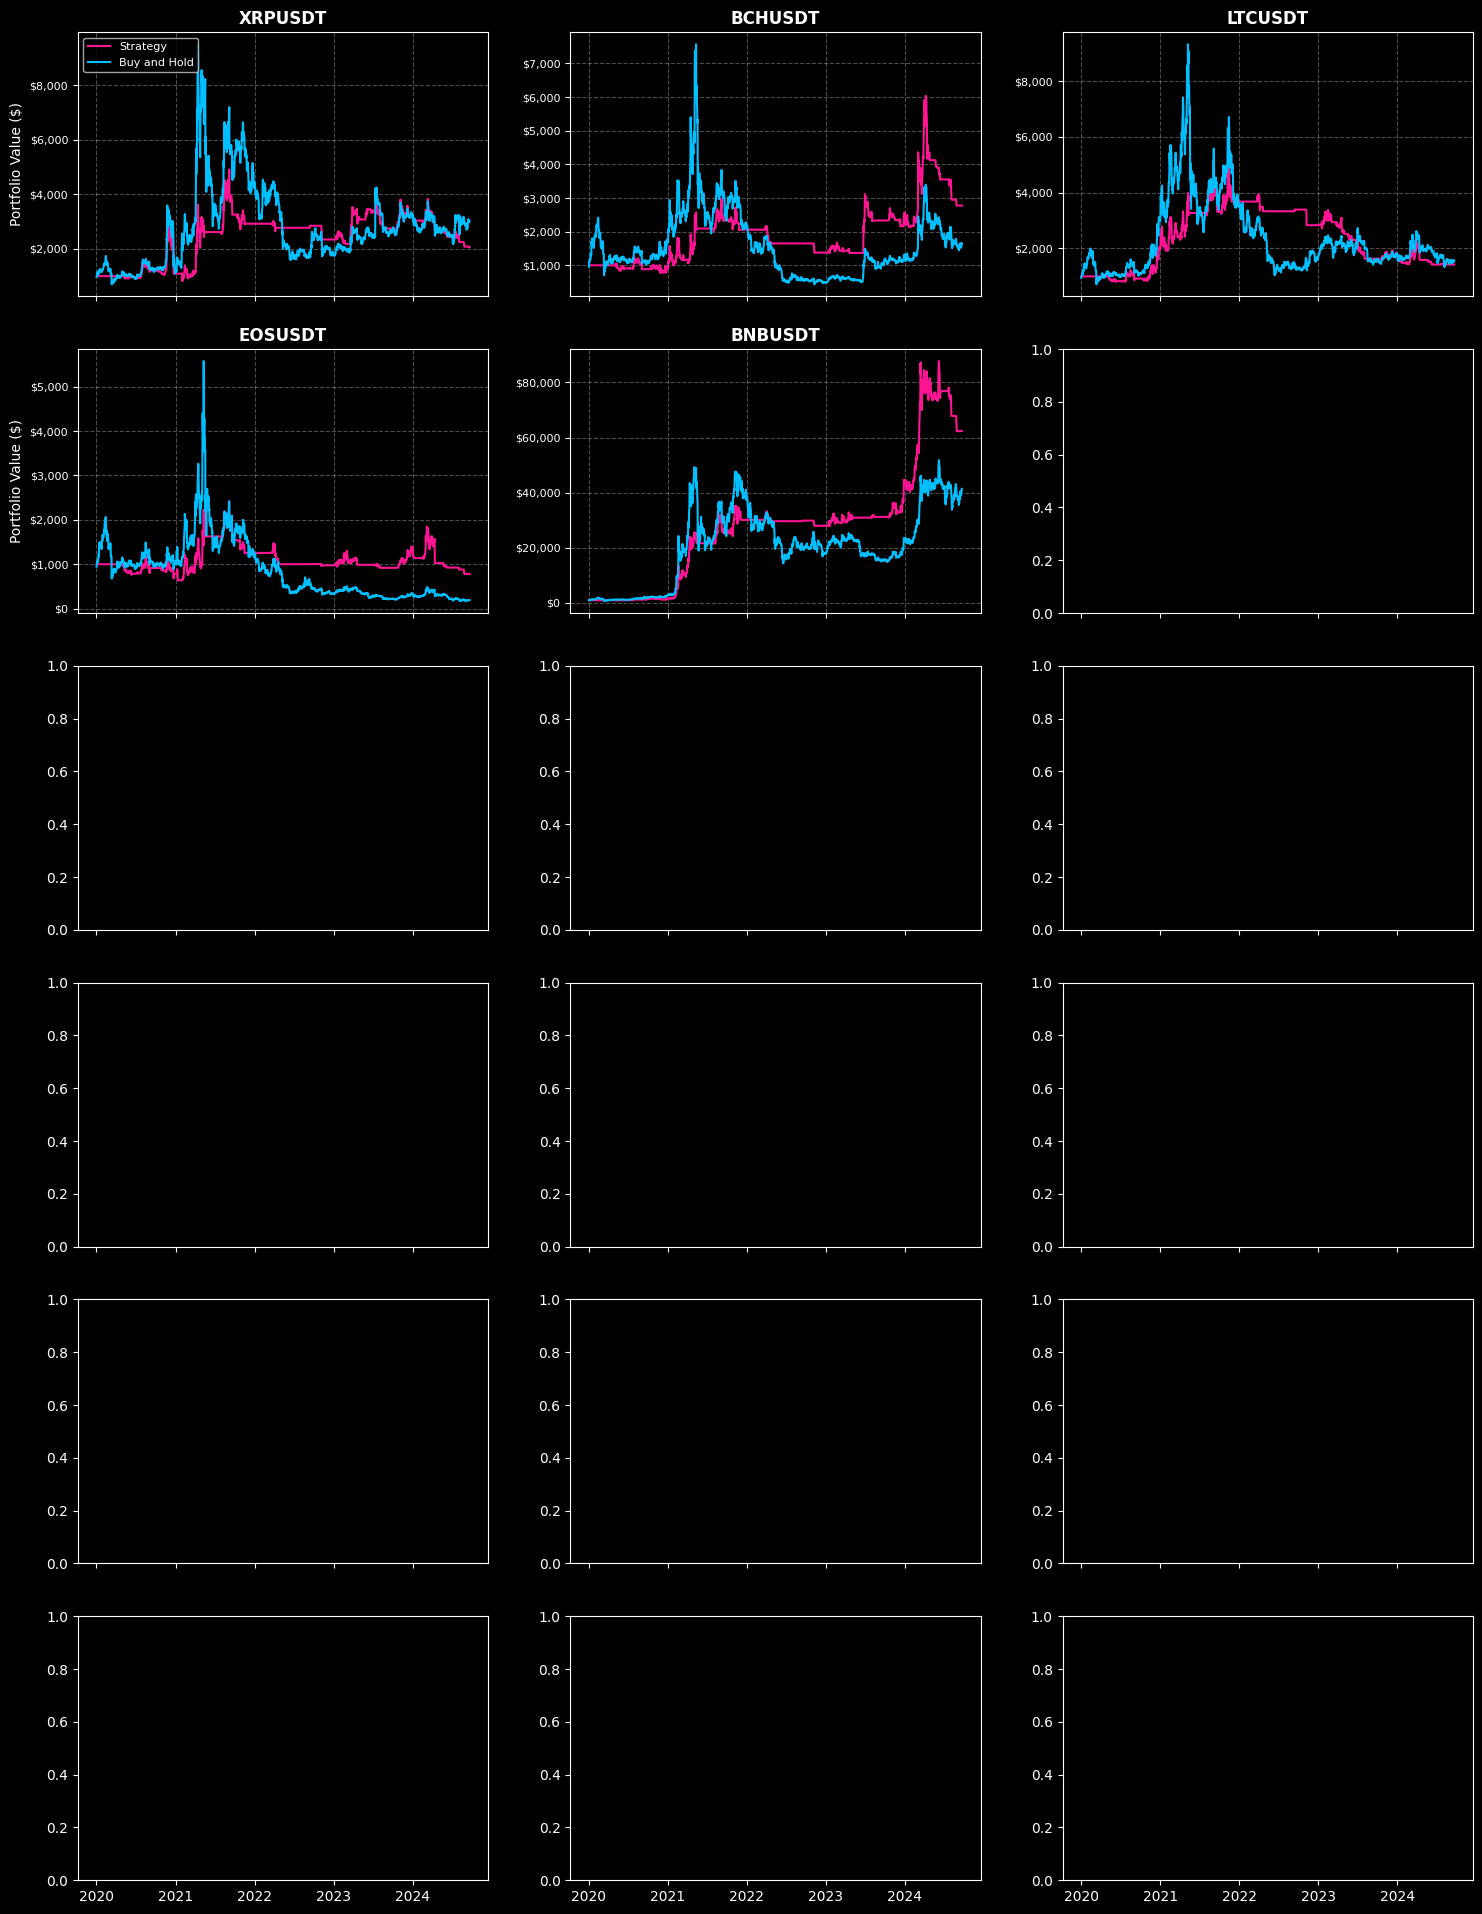

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth
    return df

def plot_strategies(df_dict, coins, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    fig.patch.set_facecolor('#000000')

    for i, coin in enumerate(coins):
        ax = axes[i // cols, i % cols]
        df = df_dict[coin]
        
        ax.plot(df.index, df['strategy'], color='#FF1493', linewidth=1.5, label='Strategy')
        ax.plot(df.index, df['buy_and_hold'], color='#00BFFF', linewidth=1.5, label='Buy and Hold')
        
        ax.set_title(f'{coin}', fontsize=12, fontweight='bold', color='white')
        ax.tick_params(axis='both', colors='white', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_facecolor('#000000')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        if i % cols == 0:
            ax.set_ylabel('Portfolio Value ($)', fontsize=10, color='white')
        if i >= len(coins) - cols:
            ax.set_xlabel('Date', fontsize=10, color='white')
        
        if i == 0:
            ax.legend(fontsize=8, loc='upper left')

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'BSVUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LEOUSDT', 'ATOMUSDT', 'HTUSDT', 'NEOUSDT', 
         '999USDT', 'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        df = backtest(df, coin, btc_window, coin_window)
        df_dict[coin] = df
    except:
        print(f'Skipping {coin}')
        continue

# Calculate rows and columns for the plot grid
n_coins = len(coins)
cols = 3
rows = (n_coins + cols - 1) // cols

plot_strategies(df_dict, coins, rows, cols)

Processing XRPUSDT...
Processing BCHUSDT...
Processing LTCUSDT...
Processing EOSUSDT...
Processing BNBUSDT...
Processing ETCUSDT...
Processing XMRUSDT...
Processing XLMUSDT...
Processing TRXUSDT...
Processing ADAUSDT...
Processing XTZUSDT...
Processing IOTAUSDT...
Processing ATOMUSDT...
Processing DASHSDT...
Skipping DASHSDT: APIError(code=-1121): Invalid symbol.
Processing NEOUSDT...
Processing CROUSDT...
Skipping CROUSDT: APIError(code=-1121): Invalid symbol.
Processing LINKUSDT...


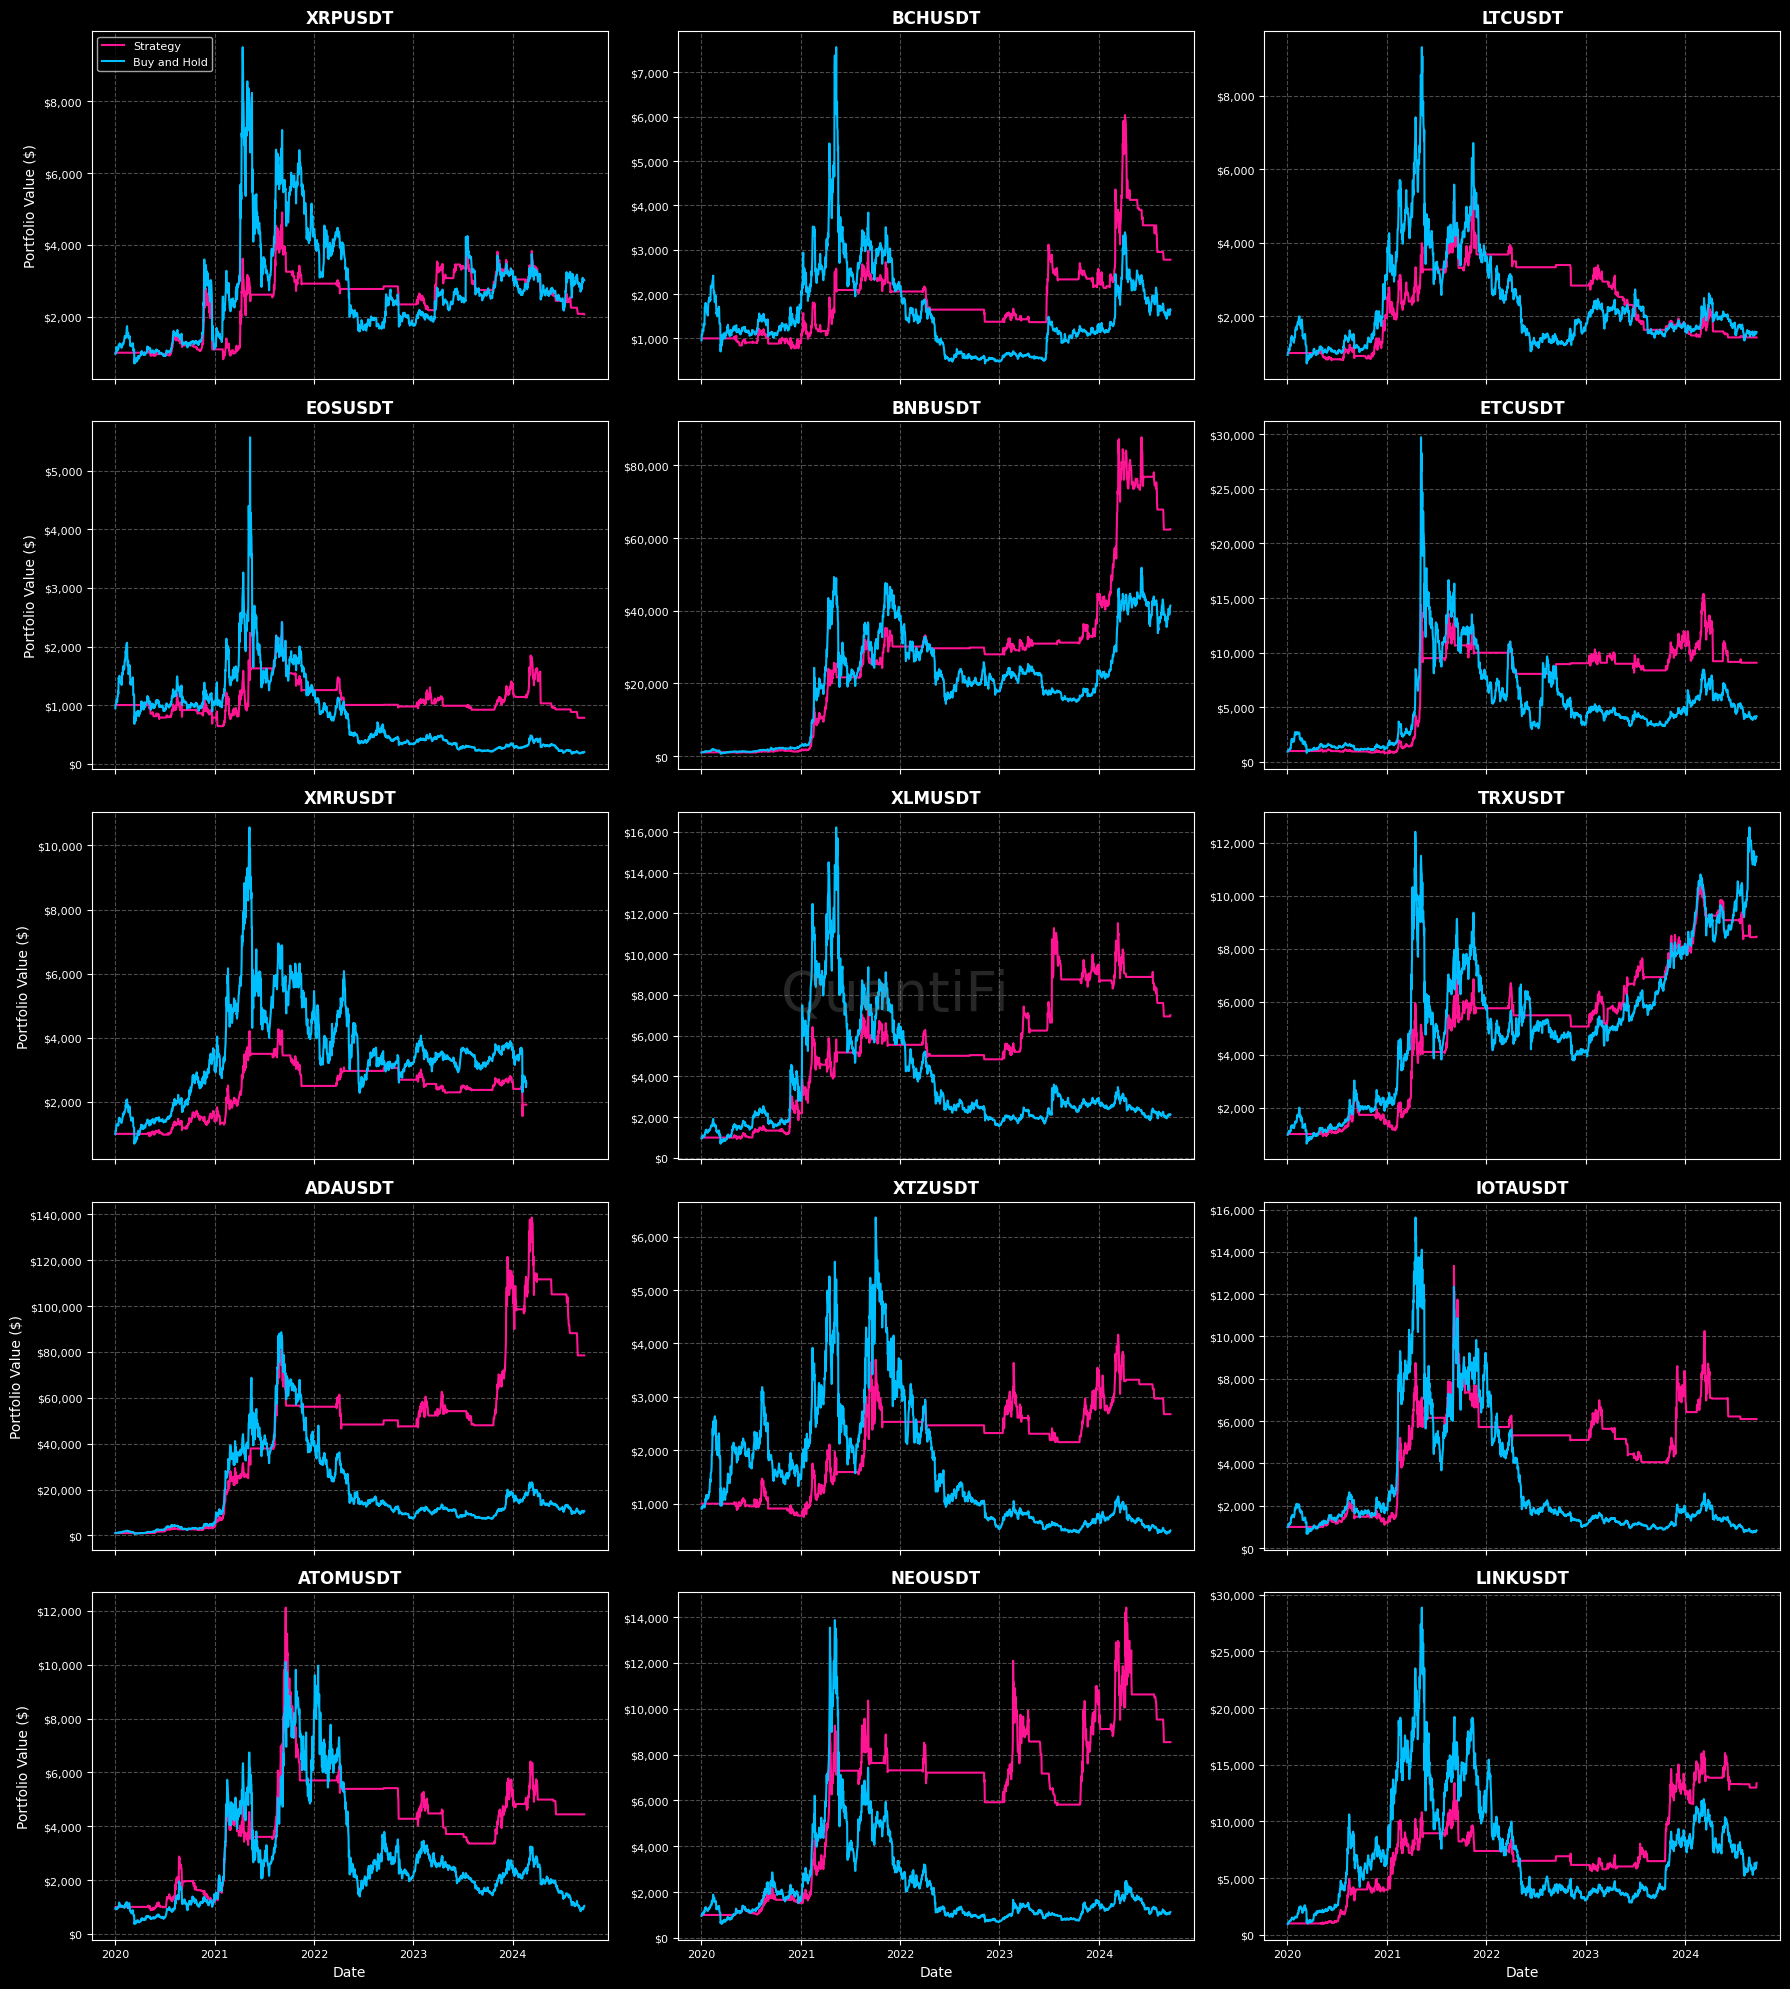

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth
    return df

def plot_strategies(df_dict, cols=3):
    n_coins = len(df_dict)
    rows = (n_coins + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    fig.patch.set_facecolor('#000000')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (coin, df) in enumerate(df_dict.items()):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        
        ax.plot(df.index, df['strategy'], color='#FF1493', linewidth=1.5, label='Strategy')
        ax.plot(df.index, df['buy_and_hold'], color='#00BFFF', linewidth=1.5, label='Buy and Hold')
        
        ax.set_title(f'{coin}', fontsize=12, fontweight='bold', color='white')
        ax.tick_params(axis='both', colors='white', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_facecolor('#000000')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        if col == 0:
            ax.set_ylabel('Portfolio Value ($)', fontsize=10, color='white')
        if row == rows - 1:
            ax.set_xlabel('Date', fontsize=10, color='white')
        
        if i == 0:
            ax.legend(fontsize=8, loc='upper left')

    # Remove empty subplots
    for i in range(n_coins, rows * cols):
        row, col = divmod(i, cols)
        fig.delaxes(axes[row, col])

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'ETCUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'IOTAUSDT', 'ATOMUSDT', 'DASHSDT', 'NEOUSDT', 
         'CROUSDT', 'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        df = backtest(df, coin, btc_window, coin_window)
        df_dict[coin] = df
    except Exception as e:
        print(f'Skipping {coin}: {str(e)}')
        continue

# Plot strategies
plot_strategies(df_dict)

Processing XRPUSDT...
Processing BCHUSDT...
Processing LTCUSDT...
Processing EOSUSDT...
Processing BNBUSDT...
Processing ETCUSDT...
Processing XMRUSDT...
Processing XLMUSDT...
Processing TRXUSDT...
Processing ADAUSDT...
Processing XTZUSDT...
Processing IOTAUSDT...
Processing ATOMUSDT...
Processing NEOUSDT...
Processing LINKUSDT...


/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_32228/908453922.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2943.6006122689273' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[current_date, f'{coin}_position'] = allocation_per_coin / df_dict[coin].loc[current_date, coin]
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_32228/908453922.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '666.6666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[current_date, f'{coin}_value'] = allocation_per_coin
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_32228/908453922.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future

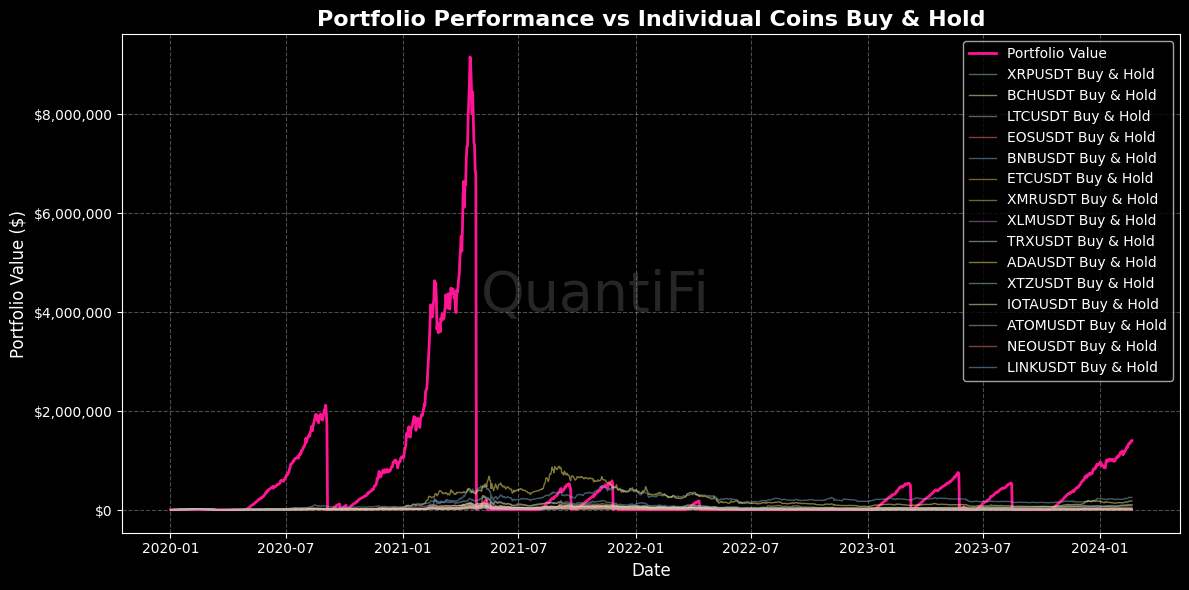

Initial Portfolio Value: $10,000.00
Final Portfolio Value: $1,404,997.71
Total Return: 13949.98%
Annualized Return: 1.28%


In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def portfolio_backtest(df_dict, btc_window, coin_window, initial_cash=10000):
    # Ensure all dataframes have the same index
    common_index = sorted(set.intersection(*[set(df.index) for df in df_dict.values()]))
    for coin in df_dict:
        df_dict[coin] = df_dict[coin].loc[common_index]

    portfolio = pd.DataFrame(index=common_index)
    portfolio['cash'] = initial_cash
    portfolio['total_value'] = initial_cash

    for coin in df_dict:
        portfolio[f'{coin}_position'] = 0
        portfolio[f'{coin}_value'] = 0

    for i in range(1, len(common_index)):
        current_date = common_index[i]
        prev_date = common_index[i-1]

        # Update values of current positions
        for coin in df_dict:
            if portfolio.loc[prev_date, f'{coin}_position'] > 0:
                portfolio.loc[current_date, f'{coin}_value'] = (
                    portfolio.loc[prev_date, f'{coin}_position'] * 
                    df_dict[coin].loc[current_date, coin]
                )

        # Calculate total value
        portfolio.loc[current_date, 'total_value'] = (
            portfolio.loc[current_date, 'cash'] + 
            sum(portfolio.loc[current_date, f'{coin}_value'] for coin in df_dict)
        )

        # Generate signals
        active_coins = []
        for coin in df_dict:
            df = df_dict[coin]
            if (df.loc[current_date, 'BTCUSDT'] > df.loc[current_date, 'BTC-SMA']) and \
               (df.loc[current_date, coin] > df.loc[current_date, f'{coin}-SMA']):
                active_coins.append(coin)

        # Rebalance portfolio
        if active_coins:
            allocation_per_coin = portfolio.loc[current_date, 'total_value'] / len(active_coins)
            for coin in df_dict:
                if coin in active_coins:
                    portfolio.loc[current_date, f'{coin}_position'] = allocation_per_coin / df_dict[coin].loc[current_date, coin]
                    portfolio.loc[current_date, f'{coin}_value'] = allocation_per_coin
                else:
                    portfolio.loc[current_date, f'{coin}_position'] = 0
                    portfolio.loc[current_date, f'{coin}_value'] = 0
            portfolio.loc[current_date, 'cash'] = 0
        else:
            # If no active coins, move everything to cash
            portfolio.loc[current_date, 'cash'] = portfolio.loc[current_date, 'total_value']
            for coin in df_dict:
                portfolio.loc[current_date, f'{coin}_position'] = 0
                portfolio.loc[current_date, f'{coin}_value'] = 0

    return portfolio

def plot_portfolio_performance(portfolio, df_dict):
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('#000000')
    ax.set_facecolor('#000000')

    # Plot portfolio value
    ax.plot(portfolio.index, portfolio['total_value'], color='#FF1493', linewidth=2, label='Portfolio Value')

    # Plot buy-and-hold for each coin
    for coin, df in df_dict.items():
        buy_and_hold = (df[coin].pct_change() + 1).cumprod() * portfolio['total_value'].iloc[0]
        ax.plot(df.index, buy_and_hold, linewidth=1, alpha=0.5, label=f'{coin} Buy & Hold')

    ax.set_title('Portfolio Performance vs Individual Coins Buy & Hold', fontsize=16, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel('Portfolio Value ($)', fontsize=12, color='white')
    ax.tick_params(axis='both', colors='white')
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Format y-axis as currency
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'ETCUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'IOTAUSDT', 'ATOMUSDT', 'NEOUSDT', 
         'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
        df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
        df_dict[coin] = df
    except Exception as e:
        print(f'Skipping {coin}: {str(e)}')
        continue

# Run portfolio backtest
portfolio = portfolio_backtest(df_dict, btc_window, coin_window)

# Plot portfolio performance
plot_portfolio_performance(portfolio, df_dict)

# Print performance metrics
initial_value = portfolio['total_value'].iloc[0]
final_value = portfolio['total_value'].iloc[-1]
total_return = (final_value / initial_value - 1) * 100
annualized_return = (final_value / initial_value) ** (252 / len(portfolio)) - 1

print(f"Initial Portfolio Value: ${initial_value:,.2f}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")

Processing XRPUSDT...
Processing BCHUSDT...
Processing LTCUSDT...
Processing EOSUSDT...
Processing BNBUSDT...
Processing ETCUSDT...
Processing XMRUSDT...
Processing XLMUSDT...
Processing TRXUSDT...
Processing ADAUSDT...
Processing XTZUSDT...
Processing IOTAUSDT...
Processing ATOMUSDT...
Processing NEOUSDT...
Processing LINKUSDT...


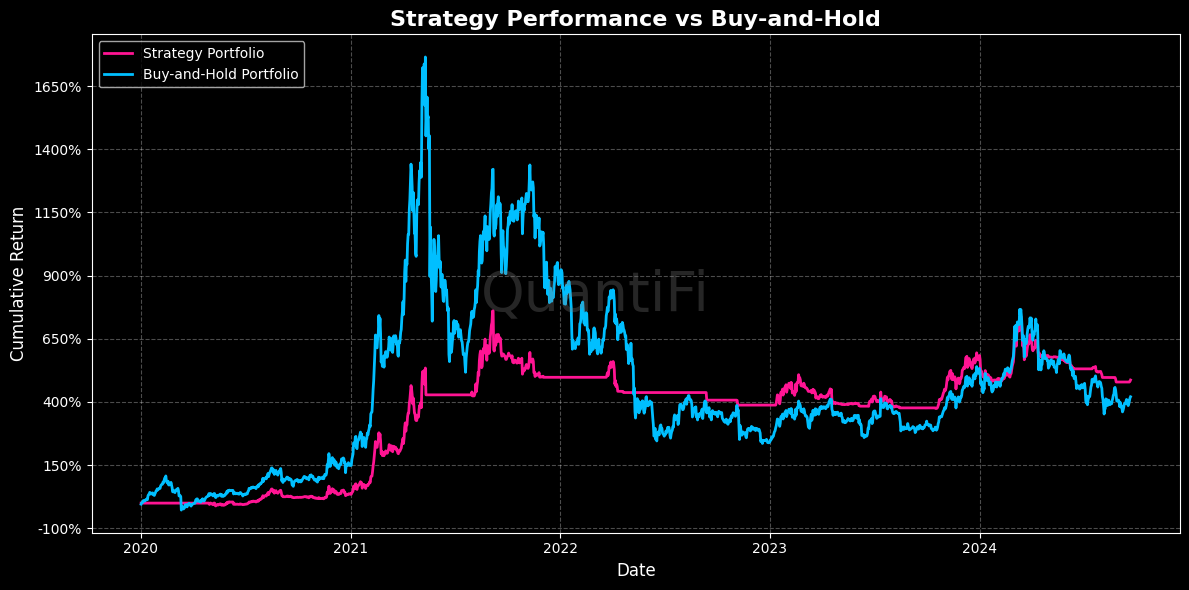


Strategy Portfolio:
Total Return: 486.98%
Annualized Return: 29.50%
Annualized Volatility: 38.51%
Sharpe Ratio: 0.71

Buy_hold Portfolio:
Total Return: 420.62%
Annualized Return: 27.26%
Annualized Volatility: 69.07%
Sharpe Ratio: 0.37


In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def backtest(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position']
    df['buy_hold_return'] = df[coin].pct_change()
    return df

def combine_returns(df_dict):
    combined_returns = pd.DataFrame()
    
    # Strategy returns
    for coin, df in df_dict.items():
        combined_returns[f'{coin}_strategy'] = df['strategy_return']
    
    # Buy-and-hold returns
    for coin, df in df_dict.items():
        combined_returns[f'{coin}_buy_hold'] = df['buy_hold_return']
    
    
    # Calculate portfolio returns
    combined_returns['strategy_return'] = combined_returns[[col for col in combined_returns.columns if col.endswith('_strategy')]].mean(axis=1)
    combined_returns['buy_hold_return'] = combined_returns[[col for col in combined_returns.columns if col.endswith('_buy_hold')]].mean(axis=1)
    
    # Calculate cumulative returns
    for col in ['strategy_return', 'buy_hold_return']:
        combined_returns[f'{col}_cumulative'] = (1 + combined_returns[col]).cumprod()
    
    return combined_returns

def plot_performance_comparison(combined_returns):
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('#000000')
    ax.set_facecolor('#000000')

    # Plot cumulative returns
    ax.plot(combined_returns.index, combined_returns['strategy_return_cumulative'], 
            color='#FF1493', linewidth=2, label='Strategy Portfolio')
    ax.plot(combined_returns.index, combined_returns['buy_hold_return_cumulative'], 
            color='#00BFFF', linewidth=2, label='Buy-and-Hold Portfolio')

    ax.set_title('Strategy Performance vs Buy-and-Hold', fontsize=16, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel('Cumulative Return', fontsize=12, color='white')
    ax.tick_params(axis='both', colors='white')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()


# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'ETCUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'IOTAUSDT', 'ATOMUSDT', 'NEOUSDT', 
         'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        if coin != 'BTCUSDT':
            df = backtest(df, coin, btc_window, coin_window)
        df_dict[coin] = df
    except Exception as e:
        print(f'Skipping {coin}: {str(e)}')
        continue

# Combine returns and calculate portfolio returns
combined_returns = combine_returns(df_dict)

# Plot performance comparison
plot_performance_comparison(combined_returns)

# Print performance metrics
for portfolio in ['strategy', 'buy_hold',]:
    total_return = combined_returns[f'{portfolio}_return_cumulative'].iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(combined_returns)) - 1
    volatility = combined_returns[f'{portfolio}_return'].std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.02) / volatility  # Assuming 2% risk-free rate

    print(f"\n{portfolio.capitalize()} Portfolio:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def backtest(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position']
    return df

def combine_strategy_returns(df_dict):
    # Combine strategy returns
    combined_returns = pd.DataFrame()
    for coin, df in df_dict.items():
        combined_returns[coin] = df['strategy_return']
    
    # Calculate portfolio return (average of all strategy returns)
    combined_returns['portfolio_return'] = combined_returns.mean(axis=1)
    
    # Calculate cumulative returns
    combined_returns['portfolio_cumulative_return'] = (1 + combined_returns['portfolio_return']).cumprod()
    
    for coin in df_dict.keys():
        combined_returns[f'{coin}_cumulative_return'] = (1 + combined_returns[coin]).cumprod()
    
    return combined_returns

def plot_portfolio_performance(combined_returns):
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('#000000')
    ax.set_facecolor('#000000')

    # Plot portfolio cumulative return
    ax.plot(combined_returns.index, combined_returns['portfolio_cumulative_return'], 
            color='#FF1493', linewidth=2, label='Portfolio')

    # Plot individual coin cumulative returns
    for coin in combined_returns.columns:
        if coin.endswith('_cumulative_return') and coin != 'portfolio_cumulative_return':
            ax.plot(combined_returns.index, combined_returns[coin], 
                    linewidth=1, alpha=0.5, label=coin.replace('_cumulative_return', ''))

    ax.set_title('Portfolio Performance vs Individual Coins', fontsize=16, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel('Cumulative Return', fontsize=12, color='white')
    ax.tick_params(axis='both', colors='white')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'ETCUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'IOTAUSDT', 'ATOMUSDT', 'NEOUSDT', 
         'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        df = backtest(df, coin, btc_window, coin_window)
        df_dict[coin] = df
    except Exception as e:
        print(f'Skipping {coin}: {str(e)}')
        continue

# Combine strategy returns and calculate portfolio return
combined_returns = combine_strategy_returns(df_dict)

# Plot portfolio performance
plot_portfolio_performance(combined_returns)

# Print performance metrics
total_return = combined_returns['portfolio_cumulative_return'].iloc[-1] - 1
annualized_return = (1 + total_return) ** (252 / len(combined_returns)) - 1
sharpe_ratio = combined_returns['portfolio_return'].mean() / combined_returns['portfolio_return'].std() * np.sqrt(252)

print(f"Total Portfolio Return: {total_return:.2%}")
print(f"Annualized Portfolio Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

In [279]:
portfolio

cash   total_value  XRPUSDT_position  XRPUSDT_value  \
2020-01-01  10000.0  1.000000e+04          0.000000       0.000000   
2020-01-02  10000.0  1.000000e+04          0.000000       0.000000   
2020-01-03  10000.0  1.000000e+04          0.000000       0.000000   
2020-01-04  10000.0  1.000000e+04          0.000000       0.000000   
2020-01-05  10000.0  1.000000e+04          0.000000       0.000000   
...             ...           ...               ...            ...   
2024-02-16      0.0  1.350314e+06     184069.295091  103870.303220   
2024-02-17      0.0  1.350360e+06     188998.984209  103873.841721   
2024-02-18      0.0  1.377967e+06     176676.070472   98426.238860   
2024-02-19      0.0  1.406195e+06     178532.697584  100442.495661   
2024-02-20      0.0  1.404998e+06     178507.611687  100356.979291   

            BCHUSDT_position  BCHUSDT_value  LTCUSDT_position  LTCUSDT_value  \
2020-01-01          0.000000       0.000000          0.000000       0.000000   
2020-01-02          0.000000       0.000000          0.000000       0.000000   
2020-01-03          0.000000       0.000000          0.000000       0.000000   
2020-01-04          0.000000       0.000000          0.000000       0.000000   
2020-01-05          0.000000       0.000000          0.000000       0.000000   
...                      ...            ...               ...            ...   
2024-02-16        378.812193  103870.303220       1471.459176  103870.303220   
2024-02-17        388.603972  103873.841721       1484.548260  103873.841721   
2024-02-18        363.733329   98426.238860       1390.201114   98426.238860   
2024-02-19        367.786509  100442.495661       1408.730654  100442.495661   
2024-02-20        378.419982  100356.979291       1440.875510  100356.979291   

            EOSUSDT_position  EOSUSDT_value  ...  XTZUSDT_position  \
2020-01-01          0.000000       0.000000  ...          0.000000   
2020-01-02          0.000000       0.000000  ...          0.000000   
2020-01-03          0.000000       0.000000  ...          0.000000   
2020-01-04          0.000000       0.000000  ...          0.000000   
2020-01-05          0.000000       0.000000  ...          0.000000   
...                      ...            ...  ...               ...   
2024-02-16     135600.918042  103870.303220  ...      96176.206685   
2024-02-17     135252.398074  103873.841721  ...      97809.643805   
2024-02-18     126674.696088   98426.238860  ...      91559.291963   
2024-02-19     126981.663288  100442.495661  ...      91728.306539   
2024-02-20     125760.625677  100356.979291  ...      90656.711193   

            XTZUSDT_value  IOTAUSDT_position  IOTAUSDT_value  \
2020-01-01       0.000000           0.000000        0.000000   
2020-01-02       0.000000           0.000000        0.000000   
2020-01-03       0.000000           0.000000        0.000000   
2020-01-04       0.000000           0.000000        0.000000   
2020-01-05       0.000000           0.000000        0.000000   
...                   ...                ...             ...   
2024-02-16  103870.303220      384135.736760   103870.303220   
2024-02-17  103873.841721      392569.318674   103873.841721   
2024-02-18   98426.238860      359219.849854    98426.238860   
2024-02-19  100442.495661      354920.479366   100442.495661   
2024-02-20  100356.979291      352748.609106   100356.979291   

            ATOMUSDT_position  ATOMUSDT_value  NEOUSDT_position  \
2020-01-01           0.000000        0.000000          0.000000   
2020-01-02           0.000000        0.000000          0.000000   
2020-01-03           0.000000        0.000000          0.000000   
2020-01-04           0.000000        0.000000          0.000000   
2020-01-05           0.000000        0.000000          0.000000   
...                       ...             ...               ...   
2024-02-16       10148.539640   103870.303220       7996.174228   
2024-02-17       10109.376323   103873.841721       8179.042655   


In [277]:
df

Open_x    High_x     Low_x   BTCUSDT      Volume_x   Open_y  \
timestamp                                                                   
2020-01-01   7195.24   7255.00   7175.15   7200.85  16792.388165   1.7678   
2020-01-02   7200.77   7212.50   6924.74   6965.71  31951.483932   1.8109   
2020-01-03   6965.49   7405.00   6871.04   7344.96  68428.500451   1.7366   
2020-01-04   7345.00   7404.00   7272.21   7354.11  29987.974977   1.8030   
2020-01-05   7354.19   7495.00   7318.00   7358.75  38331.085604   1.8243   
...              ...       ...       ...       ...           ...      ...   
2024-09-16  59132.00  59210.70  57493.30  58213.99  26477.564200  10.8100   
2024-09-17  58213.99  61320.00  57610.01  60313.99  33116.258780  10.5400   
2024-09-18  60313.99  61786.24  59174.80  61759.99  36087.024690  10.6300   
2024-09-19  61759.98  63850.00  61555.00  62947.99  34332.526080  10.9000   
2024-09-20  62948.00  64133.32  62553.90  63000.00  17747.371550  11.2100   

             High_y    Low_y  LINKUSDT    Volume_y     BTC-SMA  LINKUSDT-SMA  \
timestamp                                                                      
2020-01-01   1.8548   1.7606    1.8111  1158748.32         NaN           NaN   
2020-01-02   1.8164   1.7065    1.7366  1422992.29         NaN           NaN   
2020-01-03   1.8292   1.7013    1.8040  1789613.99         NaN           NaN   
2020-01-04   1.8446   1.7840    1.8242  1241322.81         NaN           NaN   
2020-01-05   1.8413   1.7850    1.7957  1524717.40         NaN           NaN   
...             ...      ...       ...         ...         ...           ...   
2024-09-16  10.8300  10.4100   10.5400  1891935.14  61455.1554       10.8962   
2024-09-17  10.9200  10.4300   10.6300  1812776.35  61361.8139       10.8382   
2024-09-18  10.9000  10.2900   10.8900  1980319.05  61284.0138       10.7932   
2024-09-19  11.4000  10.9000   11.2100  2838273.01  61240.3513       10.7608   
2024-09-20  11.7400  11.1200   11.5400  1904290.67  61187.7114       10.7340   

            signal  position  strategy_return      strategy  buy_and_hold  
timestamp                                                                  
2020-01-01       0       NaN              NaN           NaN           NaN  
2020-01-02       0       0.0              NaN           NaN    958.864778  
2020-01-03       0       0.0         0.000000   1000.000000    996.079731  
2020-01-04       0       0.0         0.000000   1000.000000   1007.233173  
2020-01-05       0       0.0        -0.000000   1000.000000    991.496880  
...            ...       ...              ...           ...           ...  
2024-09-16       0       0.0        -0.000000  12984.088648   5819.667605  
2024-09-17       0       0.0         0.000000  12984.088648   5869.361162  
2024-09-18       1       0.0         0.000000  12984.088648   6012.920325  
2024-09-19       1       1.0         0.000000  12984.088648   6189.608525  
2024-09-20       1       1.0         0.029438  13366.314272   6371.818232  

[1725 rows x 17 columns]

Processing XRPUSDT...
Processing BCHUSDT...
Processing LTCUSDT...
Processing EOSUSDT...
Processing BNBUSDT...
Processing BSVUSDT...
Skipping BSVUSDT: APIError(code=-1121): Invalid symbol.
Processing XMRUSDT...
Processing XLMUSDT...
Processing TRXUSDT...
Processing ADAUSDT...
Processing XTZUSDT...
Processing LEOUSDT...
Skipping LEOUSDT: APIError(code=-1121): Invalid symbol.
Processing ATOMUSDT...
Processing HTUSDT...
Skipping HTUSDT: APIError(code=-1121): Invalid symbol.
Processing NEOUSDT...
Processing 999USDT...
Skipping 999USDT: APIError(code=-1121): Invalid symbol.
Processing LINKUSDT...


IndexError: index 5 is out of bounds for axis 0 with size 5

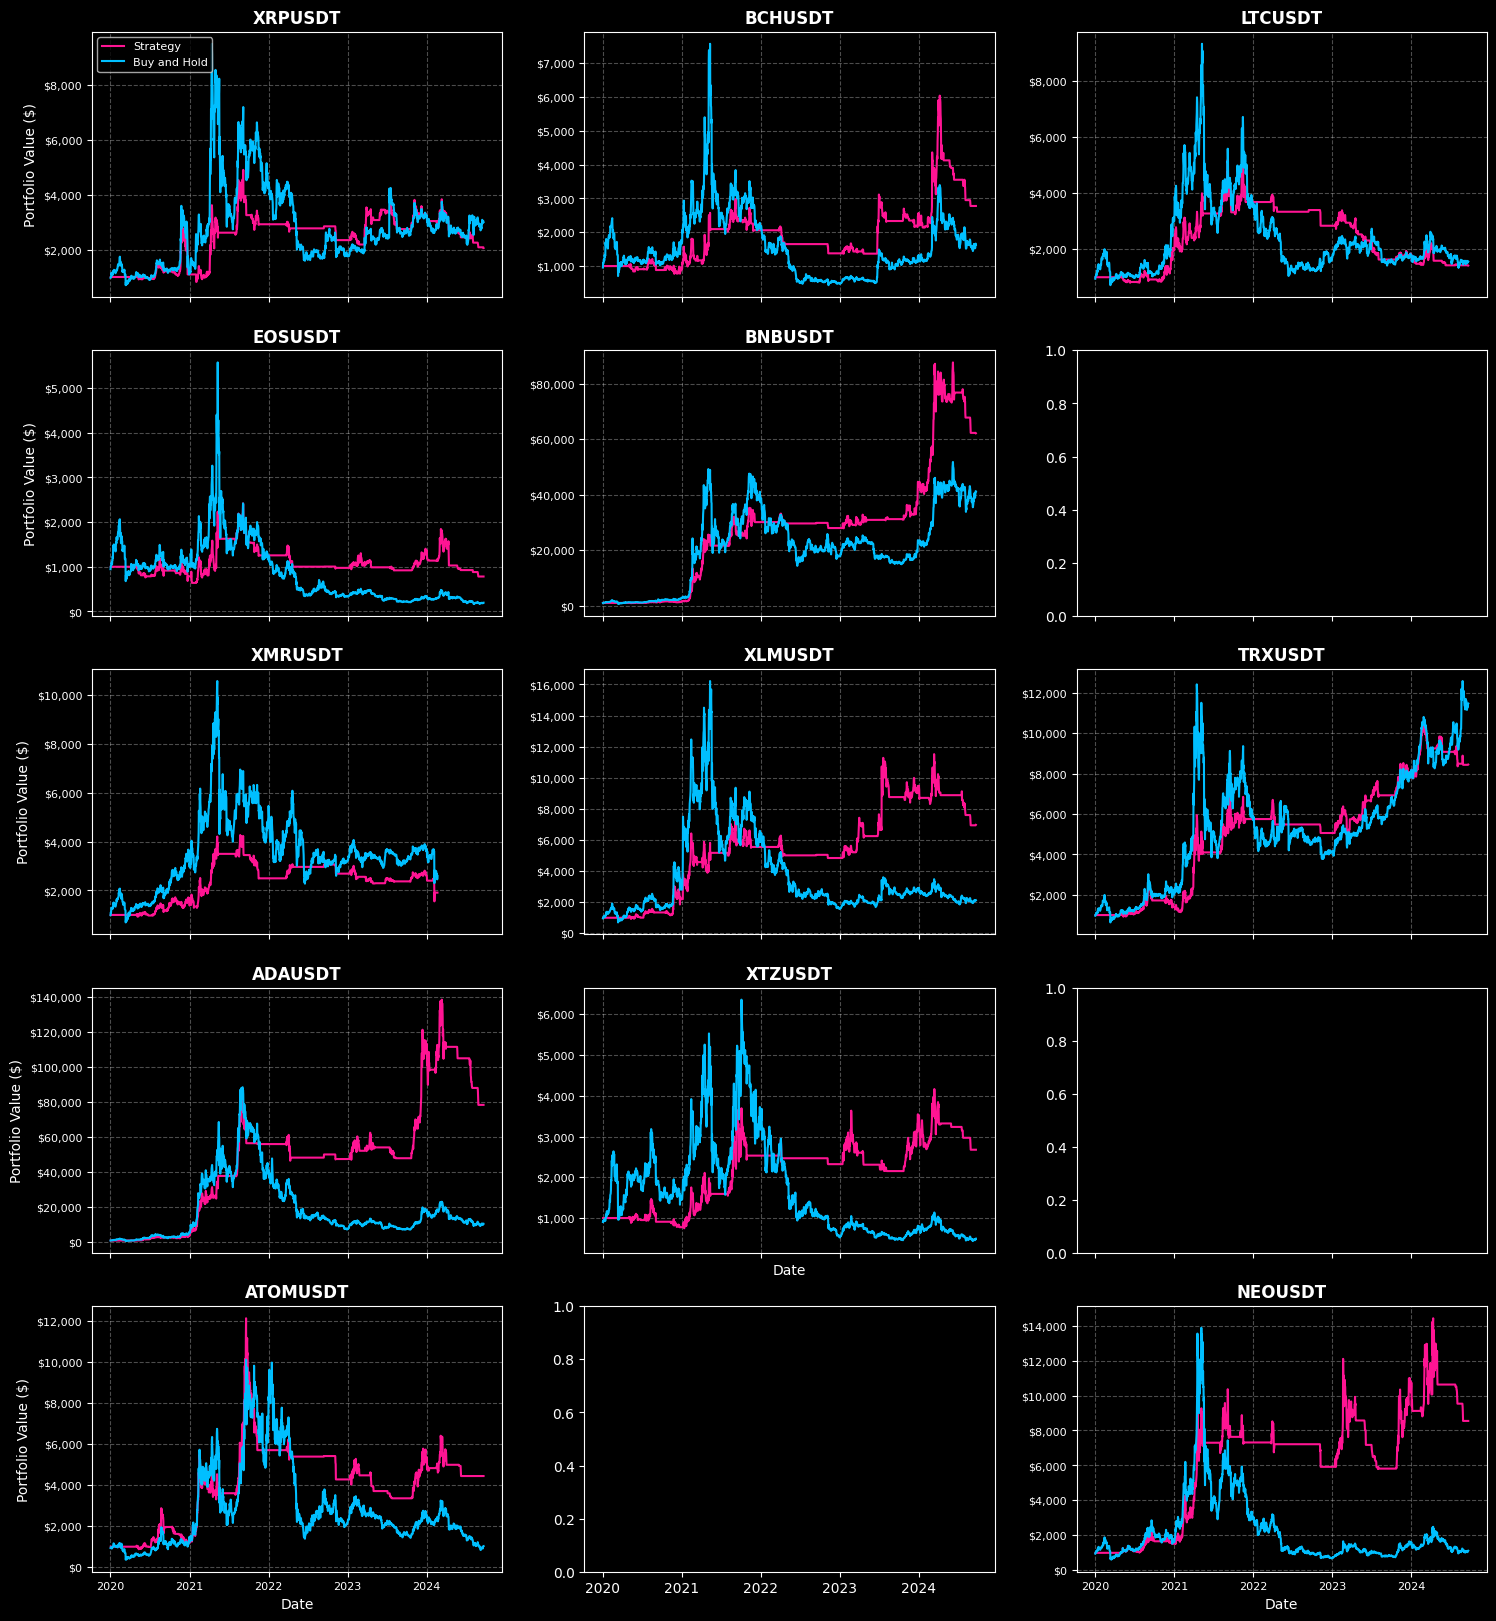

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth
    return df

def plot_strategies(df_dict, coins, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    fig.patch.set_facecolor('#000000')
    
    for i, coin in enumerate(coins):
        if coin not in df_dict:
            continue  # Skip coins that weren't successfully processed
        
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        df = df_dict[coin]
        
        ax.plot(df.index, df['strategy'], color='#FF1493', linewidth=1.5, label='Strategy')
        ax.plot(df.index, df['buy_and_hold'], color='#00BFFF', linewidth=1.5, label='Buy and Hold')
        
        ax.set_title(f'{coin}', fontsize=12, fontweight='bold', color='white')
        ax.tick_params(axis='both', colors='white', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_facecolor('#000000')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        if i % cols == 0:
            ax.set_ylabel('Portfolio Value ($)', fontsize=10, color='white')
        if i >= len(df_dict) - cols:
            ax.set_xlabel('Date', fontsize=10, color='white')
        
        if i == 0:
            ax.legend(fontsize=8, loc='upper left')

    # Remove empty subplots
    for i in range(len(df_dict), rows * cols):
        fig.delaxes(axes[i // cols, i % cols] if rows > 1 else axes[i % cols])

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'BSVUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LEOUSDT', 'ATOMUSDT', 'HTUSDT', 'NEOUSDT', 
         '999USDT', 'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        df = backtest(df, coin, btc_window, coin_window)
        df_dict[coin] = df
    except Exception as e:
        print(f'Skipping {coin}: {str(e)}')
        continue

# Calculate rows and columns for the plot grid
n_coins = len(df_dict)
cols = 3
rows = (n_coins + cols - 1) // cols

plot_strategies(df_dict, coins, rows, cols)

Processing XRPUSDT...
Processing BCHUSDT...
Processing LTCUSDT...
Processing EOSUSDT...
Processing BNBUSDT...
Processing BSVUSDT...
Skipping BSVUSDT: APIError(code=-1121): Invalid symbol.
Processing XMRUSDT...
Processing XLMUSDT...
Processing TRXUSDT...
Processing ADAUSDT...
Processing XTZUSDT...
Processing LEOUSDT...
Skipping LEOUSDT: APIError(code=-1121): Invalid symbol.
Processing ATOMUSDT...
Processing HTUSDT...
Skipping HTUSDT: APIError(code=-1121): Invalid symbol.
Processing NEOUSDT...
Processing 999USDT...
Skipping 999USDT: APIError(code=-1121): Invalid symbol.
Processing LINKUSDT...


IndexError: index 5 is out of bounds for axis 0 with size 5

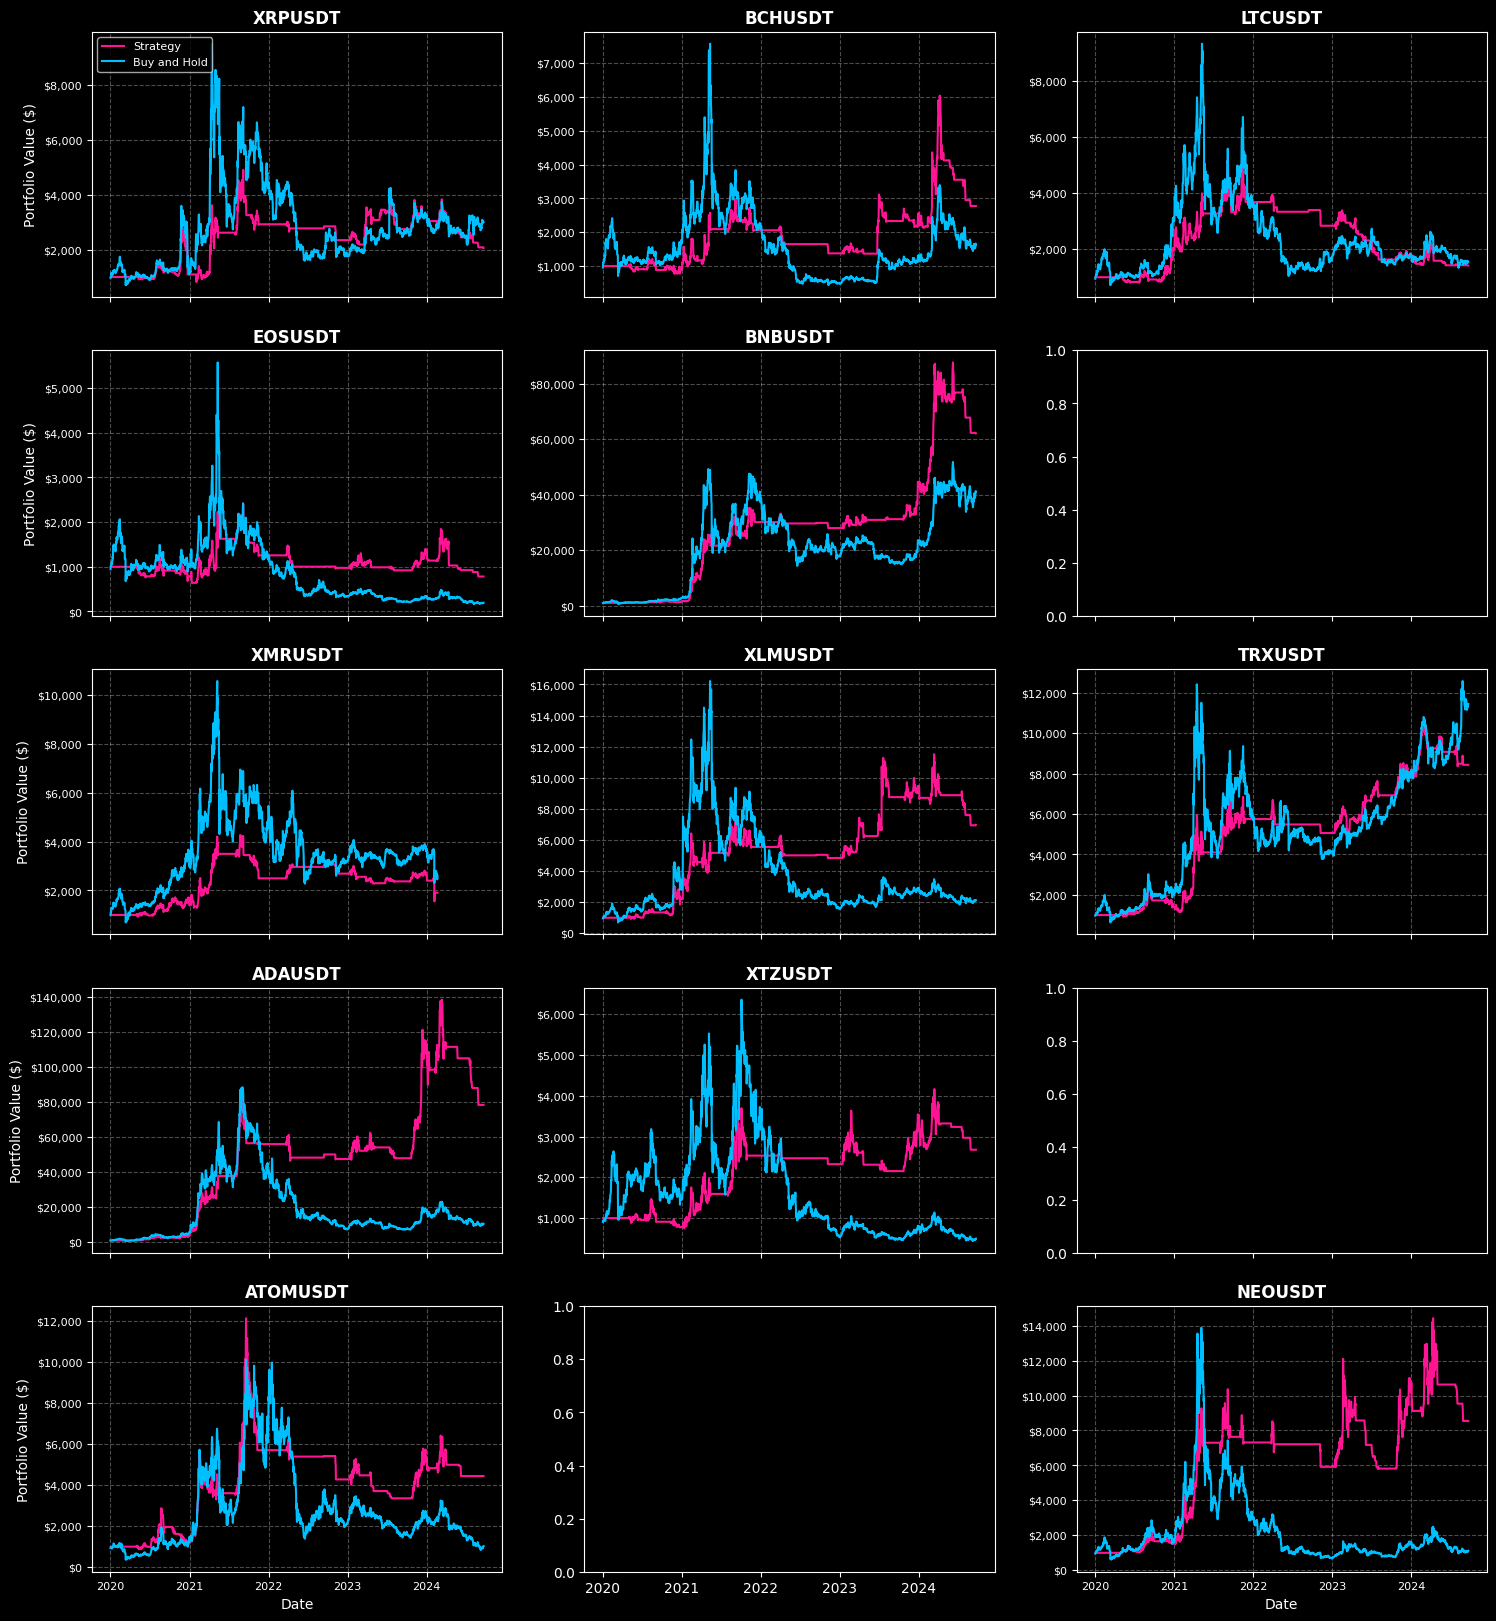

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth
    return df

def plot_strategies(df_dict, coins, cols=3):
    n_coins = len(df_dict)
    rows = (n_coins + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    fig.patch.set_facecolor('#000000')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, coin in enumerate(coins):
        if coin not in df_dict:
            continue  # Skip coins that weren't successfully processed
        
        row, col = divmod(i, cols)
        ax = axes[row, col]
        df = df_dict[coin]
        
        ax.plot(df.index, df['strategy'], color='#FF1493', linewidth=1.5, label='Strategy')
        ax.plot(df.index, df['buy_and_hold'], color='#00BFFF', linewidth=1.5, label='Buy and Hold')
        
        ax.set_title(f'{coin}', fontsize=12, fontweight='bold', color='white')
        ax.tick_params(axis='both', colors='white', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_facecolor('#000000')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        if col == 0:
            ax.set_ylabel('Portfolio Value ($)', fontsize=10, color='white')
        if row == rows - 1:
            ax.set_xlabel('Date', fontsize=10, color='white')
        
        if i == 0:
            ax.legend(fontsize=8, loc='upper left')

    # Remove empty subplots
    for i in range(n_coins, rows * cols):
        row, col = divmod(i, cols)
        fig.delaxes(axes[row, col])

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'BSVUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LEOUSDT', 'ATOMUSDT', 'HTUSDT', 'NEOUSDT', 
         '999USDT', 'LINKUSDT']

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    try:
        df = import_data(coin, start_date, end_date)
        df = backtest(df, coin, btc_window, coin_window)
        df_dict[coin] = df
    except Exception as e:
        print(f'Skipping {coin}: {str(e)}')
        continue

# Plot strategies
plot_strategies(df_dict, coins)

In [217]:
def backtest_shadowed(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['rolling_max'] = df[coin].rolling(30).max()
    df['shadow_signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'shadow_signal'] = 1
    df['shadow_position'] = df['shadow_signal'].shift(1)
    df['shadow_return'] = df[coin].pct_change() * df['shadow_position']
    df['shadow_wealth'] = (1 + df['shadow_return']).cumprod()
    return df

def backtest_actual(df, coin, equity_window=50):
    # Calculate the equity curve SMA for the shadowed strategy
    df['shadow_equity_SMA'] = df['shadow_wealth'].rolling(equity_window).mean().shift()
    
    # Generate signals for the actual strategy
    df['actual_signal'] = 0
    df.loc[df['shadow_wealth'] > df['shadow_equity_SMA'], 'actual_signal'] = df['shadow_signal']
    
    # Calculate positions, returns, and equity curve for the actual strategy
    df['actual_position'] = df['actual_signal'].shift(1)
    df['actual_return'] = df[coin].pct_change() * df['actual_position']
    df['actual_wealth'] = (1 + df['actual_return']).cumprod()
    
    return df

In [248]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.style as style
import matplotlib as mpl

def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth

    return df

def plot_strategies(df, coin_name):
    fig, ax = plt.subplots(figsize=(16, 9))
    fig.patch.set_facecolor('#000000')
    ax.set_facecolor('#000000')

    # Plot strategy and buy-and-hold
    ax.plot(df.index, df['strategy'], color='#FF1493', linewidth=2, label='Strategy')  # Flashy pink
    ax.plot(df.index, df['buy_and_hold'], color='#00BFFF', linewidth=2, label='Buy and Hold')  # Deep sky blue

    # Customize the plot
    ax.set_title(f'{coin_name} Momentum vs Buy and Hold \n Initial Capital = $1000', fontsize=20, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=14, color='white')
    ax.set_ylabel('Portfolio Value ($)', fontsize=14, color='white')
    ax.tick_params(axis='both', colors='white', labelsize=18)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Format y-axis as currency
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Add QuantiFi watermark
    fig.text(0.5, 0.02, 'QuantiFi', fontsize=40, color='gray', ha='center', va='top', alpha=0.3)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.style as style
import matplotlib as mpl

# Set the style for a dark theme
style.use('dark_background')

def get_coin_data_coingecko(coin_id, vs_currency, start_date, end_date):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': vs_currency,
        'from': int(pd.Timestamp(start_date).timestamp()),
        'to': int(pd.Timestamp(end_date).timestamp())
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop('timestamp', axis=1)
    return df

def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth
    return df

def plot_strategies(df_dict, coins, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    fig.patch.set_facecolor('#000000')

    for i, coin in enumerate(coins):
        ax = axes[i // cols, i % cols]
        df = df_dict[coin]
        
        ax.plot(df['date'], df['strategy'], color='#FF1493', linewidth=1.5, label='Strategy')
        ax.plot(df['date'], df['buy_and_hold'], color='#00BFFF', linewidth=1.5, label='Buy and Hold')
        
        ax.set_title(f'{coin}', fontsize=12, fontweight='bold', color='white')
        ax.tick_params(axis='both', colors='white', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_facecolor('#000000')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        if i % cols == 0:
            ax.set_ylabel('Portfolio Value ($)', fontsize=10, color='white')
        if i >= len(coins) - cols:
            ax.set_xlabel('Date', fontsize=10, color='white')
        
        if i == 0:
            ax.legend(fontsize=8, loc='upper left')

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coins = ['XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'BSVUSDT', 'XMRUSDT',
         'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LEOUSDT', 'ATOMUSDT', 'HTUSDT', 'NEOUSDT', 
         'LINKUSDT']  # Removed '999USDT' as it might not be available on CoinGecko

start_date = '2020-01-01'
end_date = '2024-09-20'
btc_window, coin_window = 100, 50

# Fetch Bitcoin data first
btc_df = get_coin_data_coingecko('bitcoin', 'usd', start_date, end_date)
btc_df.columns = ['BTCUSDT', 'date']

df_dict = {}
for coin in coins:
    print(f"Processing {coin}...")
    coin_id = coin.lower().replace('usdt', '')
    df = get_coin_data_coingecko(coin_id, 'usd', start_date, end_date)
    df.columns = [coin, 'date']
    df = pd.merge(btc_df, df, on='date')
    df = backtest(df, coin, btc_window, coin_window)
    df_dict[coin] = df

# Calculate rows and columns for the plot grid
n_coins = len(coins)
cols = 3
rows = (n_coins + cols - 1) // cols

plot_strategies(df_dict, coins, rows, cols)

In [295]:
def backtest(df, coin, btc_window, coin_window, initial_wealth=1000):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position'].shift()
    df['strategy'] = (1 + df['strategy_return']).cumprod() * initial_wealth
    df['buy_and_hold'] = (df[coin].pct_change() + 1).cumprod() * initial_wealth
    return df

def plot_strategies(df, coin_name):
    fig, ax = plt.subplots(figsize=(16, 9))
    fig.patch.set_facecolor('#000000')
    ax.set_facecolor('#000000')

    # Plot strategy and buy-and-hold
    ax.plot(df.index, df['strategy'], color='#FF1493', linewidth=2, label='Strategy')  # Flashy pink
    ax.plot(df.index, df['buy_and_hold'], color='#00BFFF', linewidth=2, label='Buy and Hold')  # Deep sky blue

    # Customize the plot
    ax.set_title(f'{coin_name} Momentum vs Buy and Hold \n Initial Capital = $1,000', fontsize=20, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=14, color='white')
    ax.set_ylabel('Portfolio Value ($)', fontsize=14, color='white')
    ax.tick_params(axis='both', colors='white', labelsize=18)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Format y-axis as currency
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Add QuantiFi watermark
    fig.text(0.5, 0.02, 'QuantiFi', fontsize=40, color='gray', ha='center', va='top', alpha=0.3)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

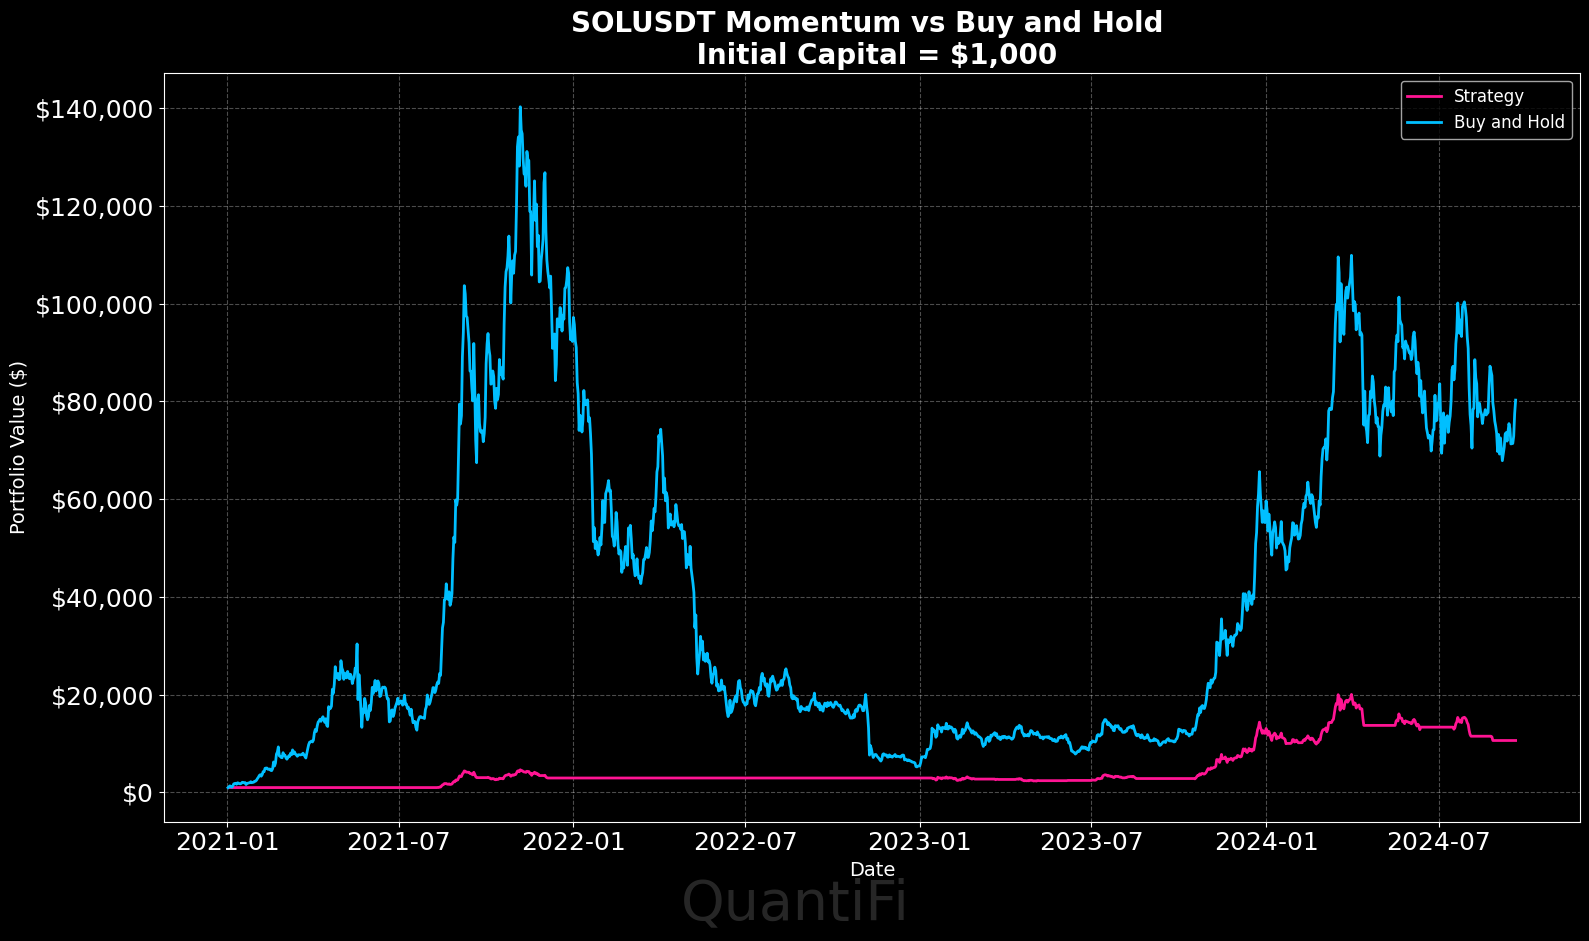

In [303]:
coin = 'SOLUSDT'

df = import_data(coin, '2021-01-01', '2024-09-20')
df = backtest(df, coin, 200, 50)
plot_strategies(df, coin)



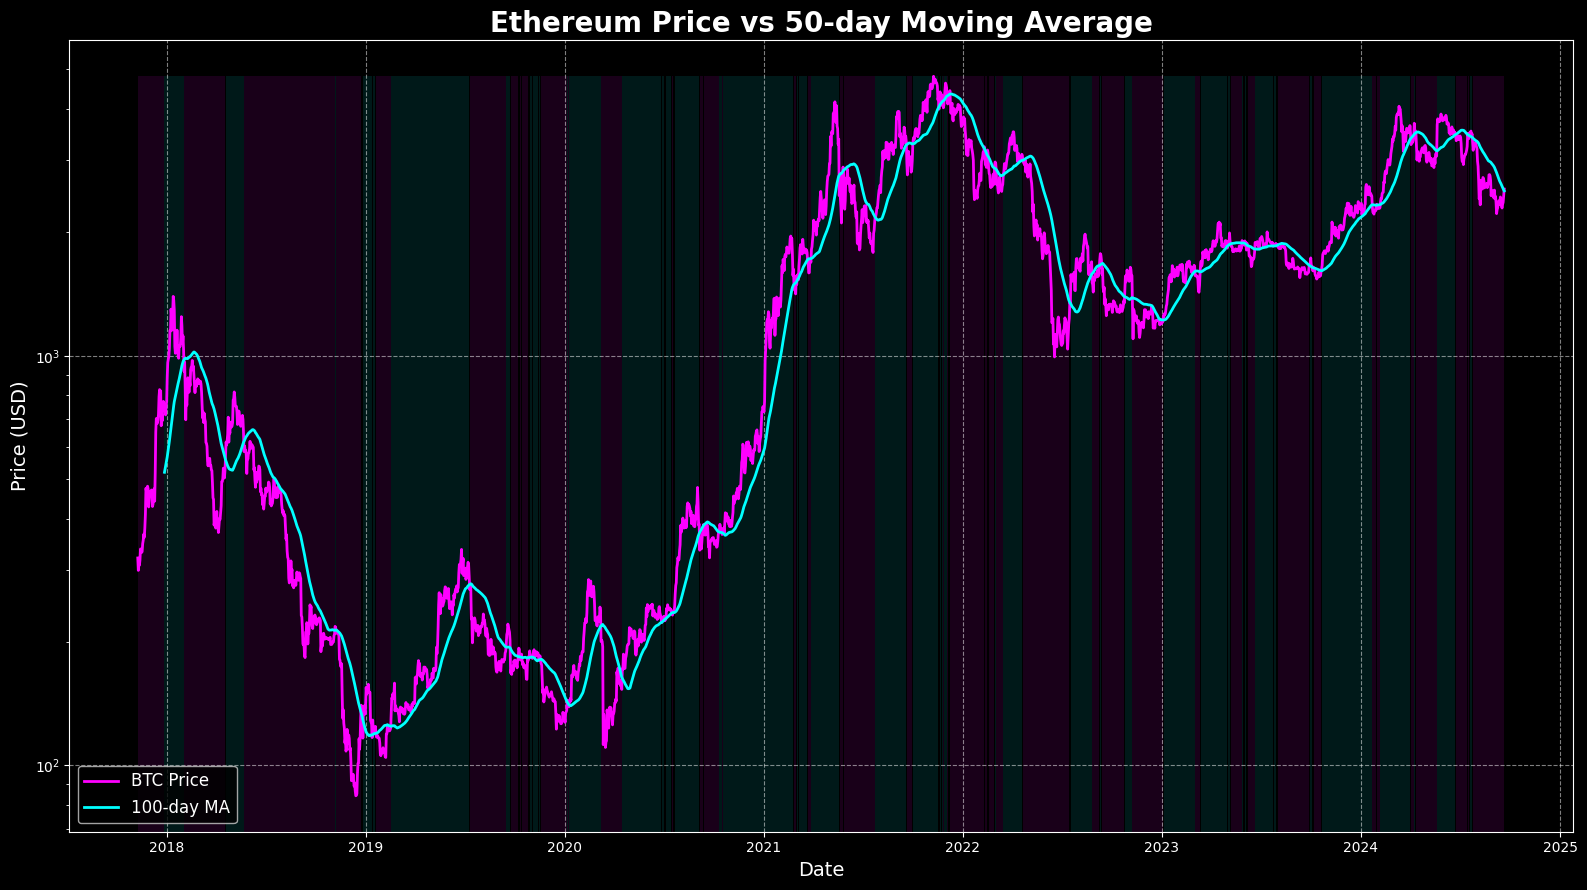

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch Bitcoin price data
btc = yf.Ticker("ETH-USD")
df = btc.history(period="max")

# Calculate 100-day Moving Average
df['MA50'] = df['Close'].rolling(window=50).mean()

# Create the plot
plt.figure(figsize=(16, 9))
plt.style.use('dark_background')

# Plot Bitcoin price
plt.plot(df.index, df['Close'], color='#FF00FF', linewidth=2, label='BTC Price')

# Plot 100-day MA
plt.plot(df.index, df['MA50'], color='#00FFFF', linewidth=2, label='100-day MA')

# Color the background based on bull/bear market
bull = df['Close'] > df['MA50']
plt.fill_between(df.index, 0, df['Close'].max(), where=bull, facecolor='#00FFFF', alpha=0.1)
plt.fill_between(df.index, 0, df['Close'].max(), where=~bull, facecolor='#FF00FF', alpha=0.1)

# Customize the plot
plt.title('Ethereum Price vs 50-day Moving Average', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')

# Show the grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

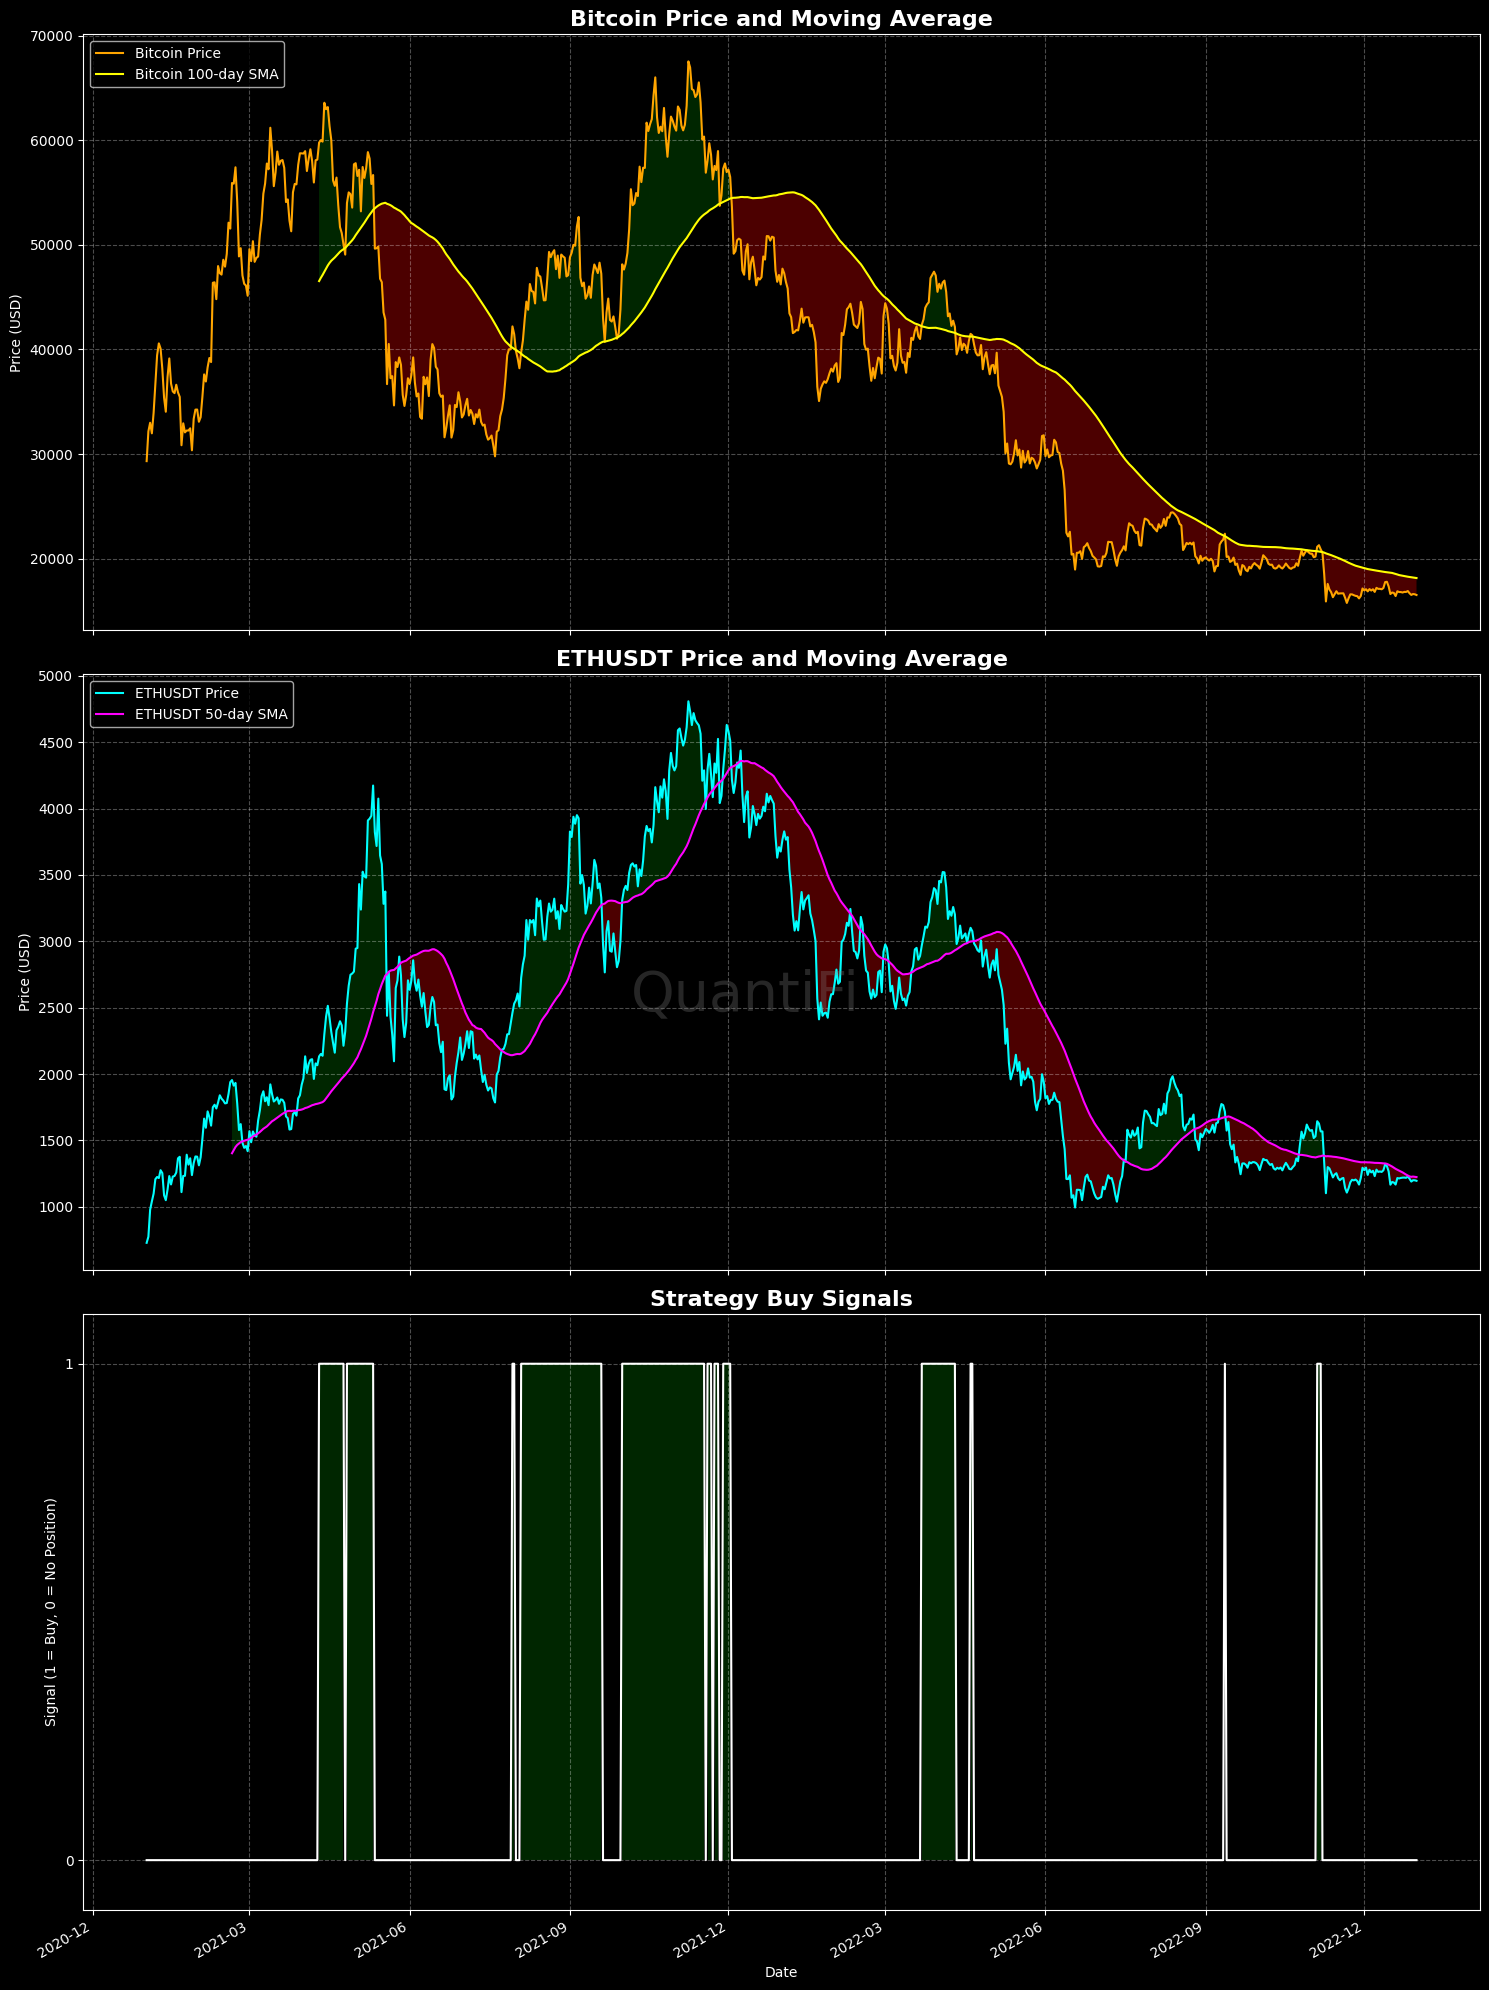

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style

style.use('dark_background')

def backtest(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    return df

def visualize_strategy_signals(df, coin, btc_window, coin_window):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
    fig.patch.set_facecolor('#000000')

    # Bitcoin price and SMA
    ax1.plot(df.index, df['BTCUSDT'], color='orange', label='Bitcoin Price')
    ax1.plot(df.index, df['BTC-SMA'], color='yellow', label=f'Bitcoin {btc_window}-day SMA')
    ax1.fill_between(df.index, df['BTCUSDT'], df['BTC-SMA'], where=df['BTCUSDT'] > df['BTC-SMA'], 
                     facecolor='green', alpha=0.3, interpolate=True)
    ax1.fill_between(df.index, df['BTCUSDT'], df['BTC-SMA'], where=df['BTCUSDT'] <= df['BTC-SMA'], 
                     facecolor='red', alpha=0.3, interpolate=True)
    ax1.set_title('Bitcoin Price and Moving Average', fontsize=16, fontweight='bold', color='white')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Price (USD)', color='white')

    # Coin price and SMA
    ax2.plot(df.index, df[coin], color='cyan', label=f'{coin} Price')
    ax2.plot(df.index, df[f'{coin}-SMA'], color='magenta', label=f'{coin} {coin_window}-day SMA')
    ax2.fill_between(df.index, df[coin], df[f'{coin}-SMA'], where=df[coin] > df[f'{coin}-SMA'], 
                     facecolor='green', alpha=0.3, interpolate=True)
    ax2.fill_between(df.index, df[coin], df[f'{coin}-SMA'], where=df[coin] <= df[f'{coin}-SMA'], 
                     facecolor='red', alpha=0.3, interpolate=True)
    ax2.set_title(f'{coin} Price and Moving Average', fontsize=16, fontweight='bold', color='white')
    ax2.legend(loc='upper left')
    ax2.set_ylabel('Price (USD)', color='white')

    # Strategy signals
    ax3.plot(df.index, df['signal'], color='white', label='Strategy Signal')
    ax3.fill_between(df.index, 0, 1, where=df['signal'] == 1, facecolor='green', alpha=0.3, step='post')
    ax3.set_title('Strategy Buy Signals', fontsize=16, fontweight='bold', color='white')
    ax3.set_ylabel('Signal (1 = Buy, 0 = No Position)', color='white')
    ax3.set_ylim(-0.1, 1.1)
    ax3.yaxis.set_ticks([0, 1])

    # Formatting
    for ax in (ax1, ax2, ax3):
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.tick_params(axis='both', colors='white')

    plt.xlabel('Date', color='white')
    fig.autofmt_xdate()  # Rotate and align the tick labels
    
    # Use MonthLocator for x-axis ticks
    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
coin = 'ETHUSDT'  # Example coin
start_date = '2021-01-01'
end_date = '2022-12-31'
btc_window, coin_window = 100, 50

try:
    df = import_data(coin, start_date, end_date)
    df = backtest(df, coin, btc_window, coin_window)
    visualize_strategy_signals(df, coin, btc_window, coin_window)
except Exception as e:
    print(f"An error occurred: {str(e)}")

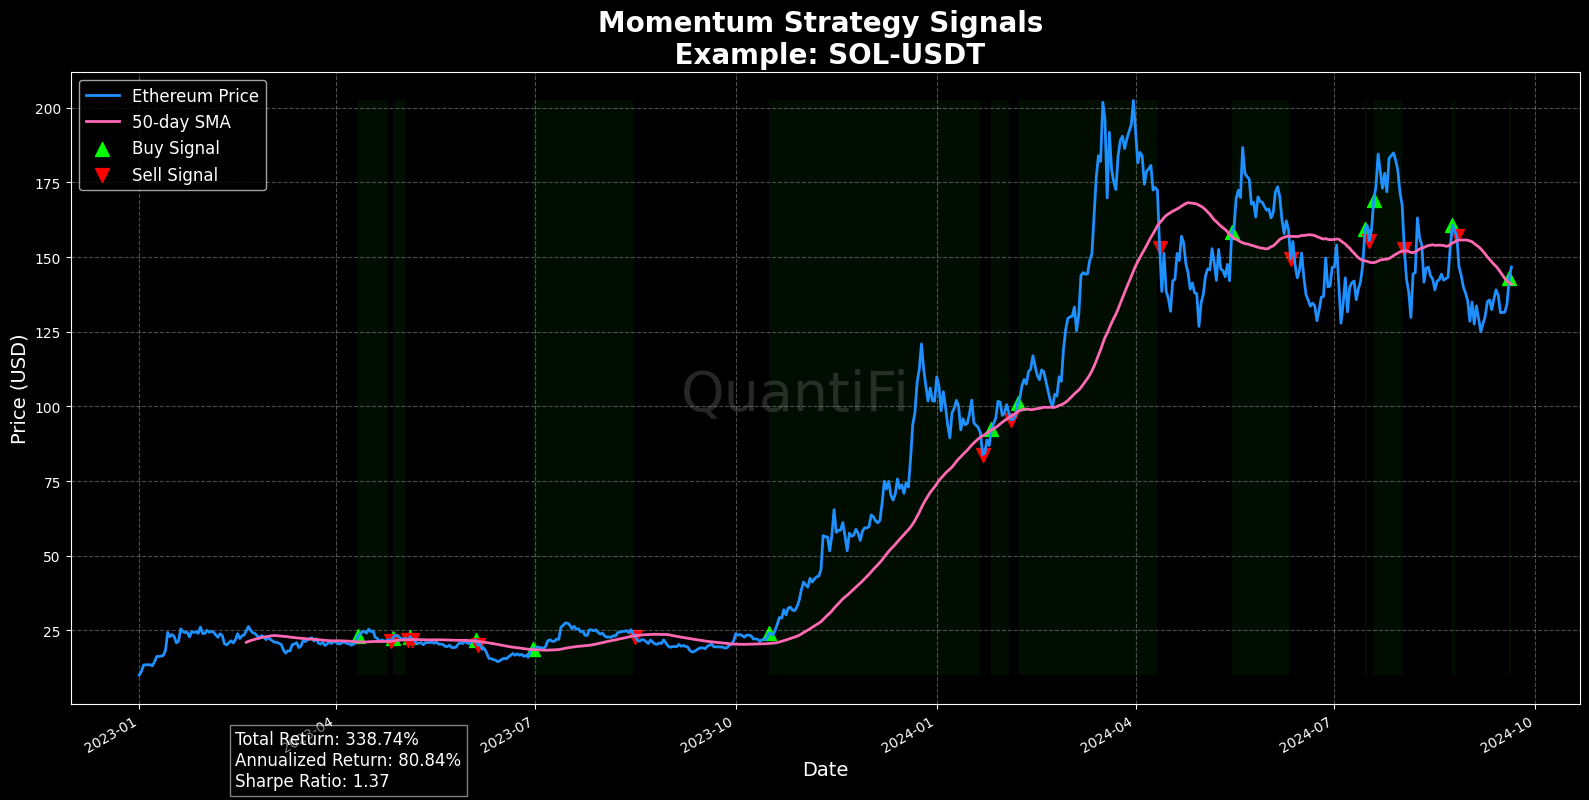

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style

style.use('dark_background')

def backtest(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position']
    return df

def visualize_ethereum_strategy(df, coin='ETHUSDT', coin_window=50):
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.patch.set_facecolor('#000000')
    ax.set_facecolor('#000000')

    # Plot Ethereum price and MA
    ax.plot(df.index, df[coin], color='#1E90FF', label='Ethereum Price', linewidth=2)
    ax.plot(df.index, df[f'{coin}-SMA'], color='#FF69B4', label=f'{coin_window}-day SMA', linewidth=2)

    # Find buy and sell signals
    buy_signals = df[df['signal'].diff() == 1]
    sell_signals = df[df['signal'].diff() == -1]

    # Plot buy signals
    ax.scatter(buy_signals.index, buy_signals[coin], color='lime', s=100, marker='^', label='Buy Signal')

    # Plot sell signals
    ax.scatter(sell_signals.index, sell_signals[coin], color='red', s=100, marker='v', label='Sell Signal')

    # Shading for positive signals
    ax.fill_between(df.index, df[coin].min(), df[coin].max(), where=df['signal'] == 1, 
                    facecolor='green', alpha=0.1)

    # Formatting
    ax.set_title('Momentum Strategy Signals \n Example: SOL-USDT', fontsize=20, fontweight='bold', color='white')
    ax.set_xlabel('Date', fontsize=14, color='white')
    ax.set_ylabel('Price (USD)', fontsize=14, color='white')
    ax.tick_params(axis='both', colors='white')
    ax.legend(loc='upper left', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Use MonthLocator for x-axis ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()  # Rotate and align the tick labels

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    # Add strategy performance text
    total_return = (1 + df['strategy_return']).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(df)) - 1
    sharpe_ratio = np.sqrt(252) * df['strategy_return'].mean() / df['strategy_return'].std()
    
    performance_text = (
        f"Total Return: {total_return:.2%}\n"
        f"Annualized Return: {annualized_return:.2%}\n"
        f"Sharpe Ratio: {sharpe_ratio:.2f}"
    )
    fig.text(0.15, 0.01, performance_text, fontsize=12, color='white', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='white'))

    plt.tight_layout()
    plt.show()

# Example usage
start_date = '2023-01-01'
end_date = '2024-09-20'
btc_window, eth_window = 100, 50

try:
    df = import_data('SOLUSDT', start_date, end_date)
    df = backtest(df, 'SOLUSDT', btc_window, eth_window)
    visualize_ethereum_strategy(df, coin='SOLUSDT', coin_window=eth_window)
except Exception as e:
    print(f"An error occurred: {str(e)}")

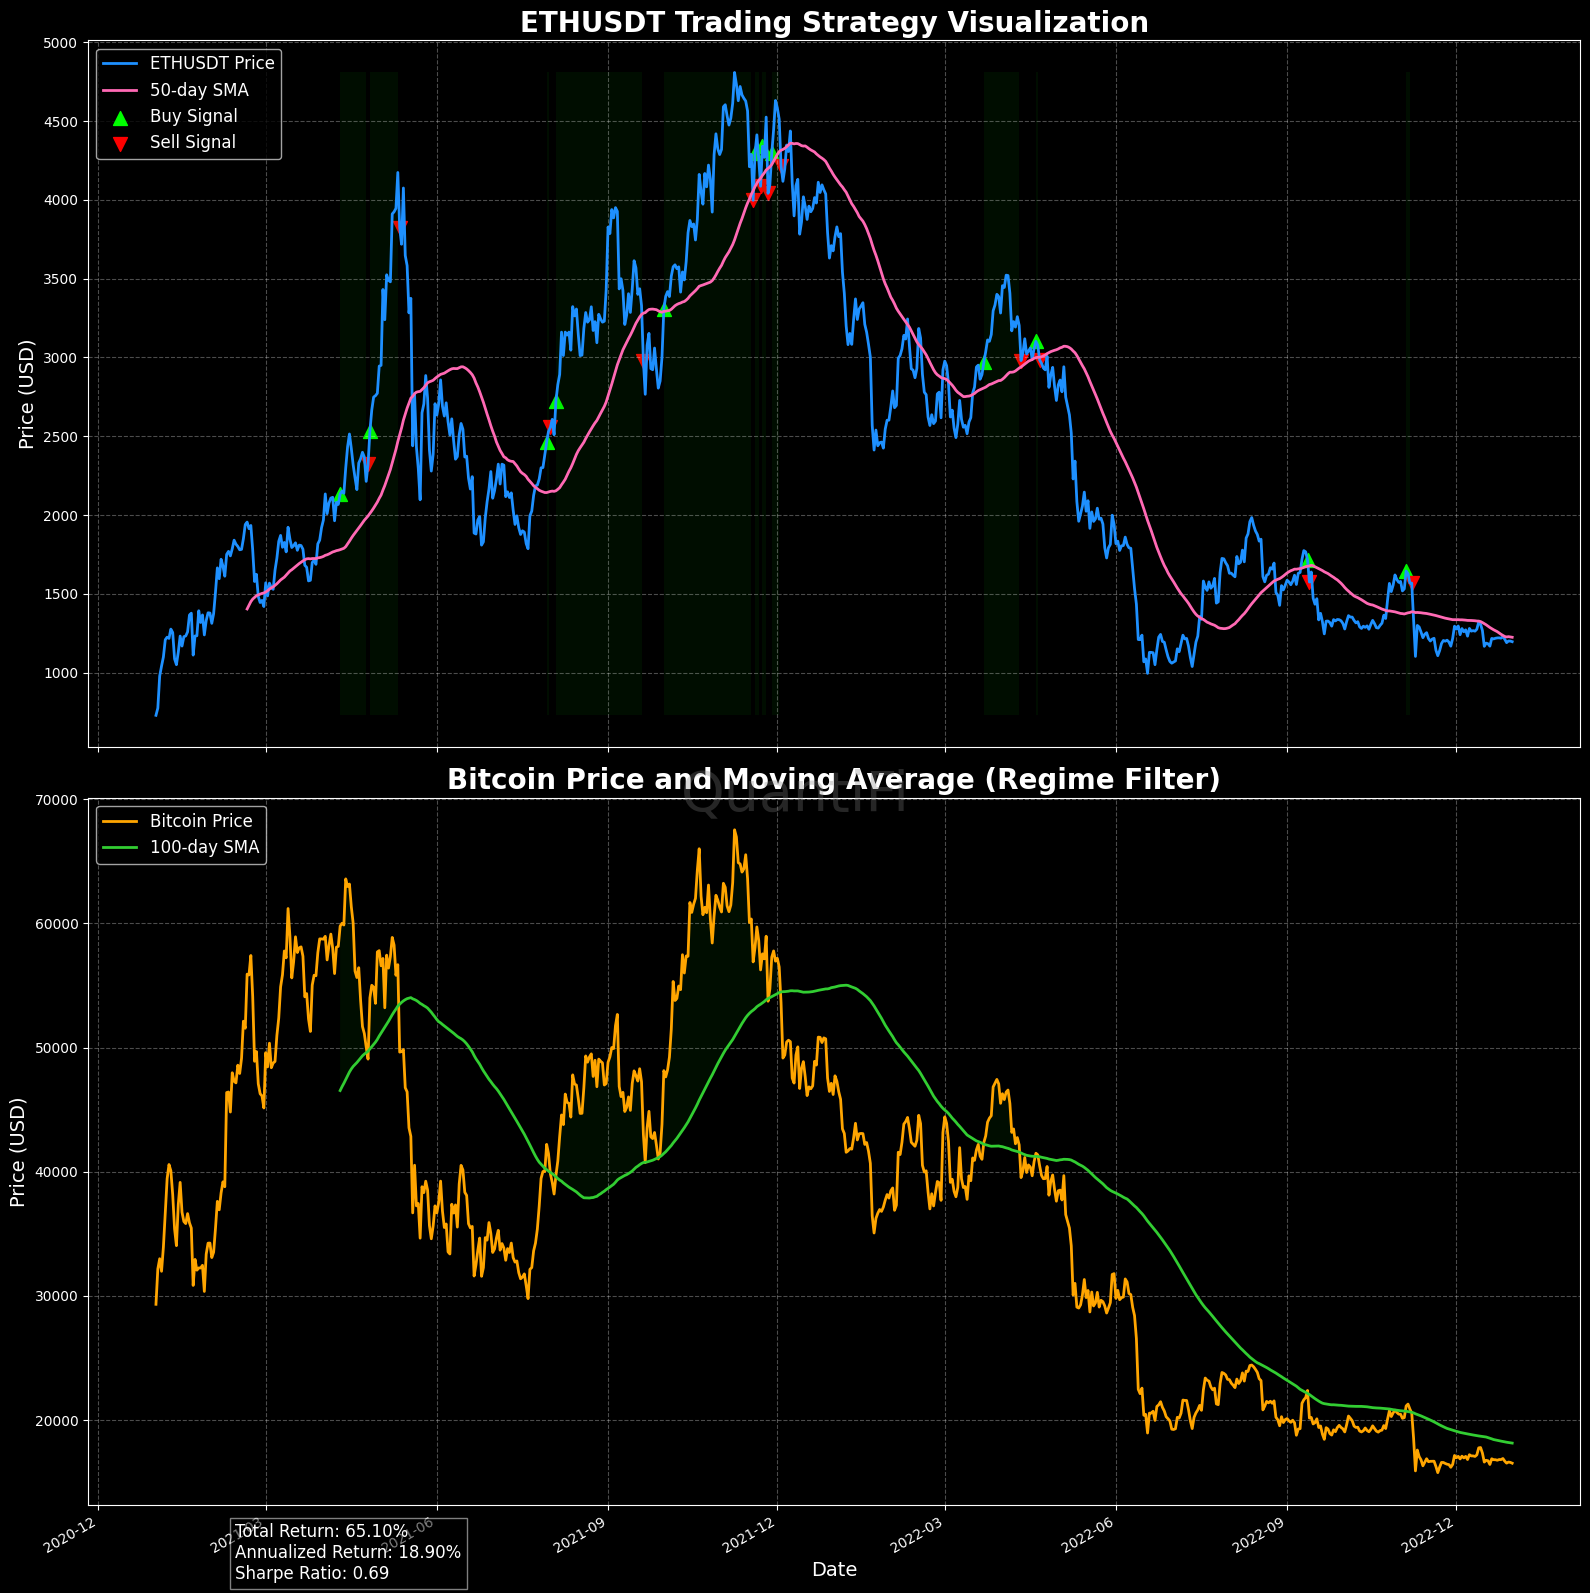

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style

style.use('dark_background')

def backtest(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position']
    return df

def visualize_strategy(df, coin='ETHUSDT', coin_window=50, btc_window=100):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), sharex=True)
    fig.patch.set_facecolor('#000000')

    # Ethereum chart
    ax1.set_facecolor('#000000')
    ax1.plot(df.index, df[coin], color='#1E90FF', label=f'{coin} Price', linewidth=2)
    ax1.plot(df.index, df[f'{coin}-SMA'], color='#FF69B4', label=f'{coin_window}-day SMA', linewidth=2)

    buy_signals = df[df['signal'].diff() == 1]
    sell_signals = df[df['signal'].diff() == -1]

    ax1.scatter(buy_signals.index, buy_signals[coin], color='lime', s=100, marker='^', label='Buy Signal')
    ax1.scatter(sell_signals.index, sell_signals[coin], color='red', s=100, marker='v', label='Sell Signal')

    ax1.fill_between(df.index, df[coin].min(), df[coin].max(), where=df['signal'] == 1, 
                     facecolor='green', alpha=0.1)

    ax1.set_title(f'{coin} Trading Strategy Visualization', fontsize=20, fontweight='bold', color='white')
    ax1.set_ylabel('Price (USD)', fontsize=14, color='white')
    ax1.tick_params(axis='both', colors='white')
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Bitcoin chart
    ax2.set_facecolor('#000000')
    ax2.plot(df.index, df['BTCUSDT'], color='#FFA500', label='Bitcoin Price', linewidth=2)
    ax2.plot(df.index, df['BTC-SMA'], color='#32CD32', label=f'{btc_window}-day SMA', linewidth=2)

    ax2.fill_between(df.index, df['BTCUSDT'], df['BTC-SMA'], 
                     where=df['BTCUSDT'] > df['BTC-SMA'], 
                     facecolor='green', alpha=0.1)

    ax2.set_title('Bitcoin Price and Moving Average (Regime Filter)', fontsize=20, fontweight='bold', color='white')
    ax2.set_xlabel('Date', fontsize=14, color='white')
    ax2.set_ylabel('Price (USD)', fontsize=14, color='white')
    ax2.tick_params(axis='both', colors='white')
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.3)

    # X-axis formatting
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    # Add strategy performance text
    total_return = (1 + df['strategy_return']).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(df)) - 1
    sharpe_ratio = np.sqrt(252) * df['strategy_return'].mean() / df['strategy_return'].std()
    
    performance_text = (
        f"Total Return: {total_return:.2%}\n"
        f"Annualized Return: {annualized_return:.2%}\n"
        f"Sharpe Ratio: {sharpe_ratio:.2f}"
    )
    fig.text(0.15, 0.01, performance_text, fontsize=12, color='white', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='white'))

    plt.tight_layout()
    plt.show()

# Example usage
start_date = '2021-01-01'
end_date = '2022-12-31'
btc_window, eth_window = 100, 50

try:
    df = import_data('ETHUSDT', start_date, end_date)
    df = backtest(df, 'ETHUSDT', btc_window, eth_window)
    visualize_strategy(df, coin='ETHUSDT', coin_window=eth_window, btc_window=btc_window)
except Exception as e:
    print(f"An error occurred: {str(e)}")

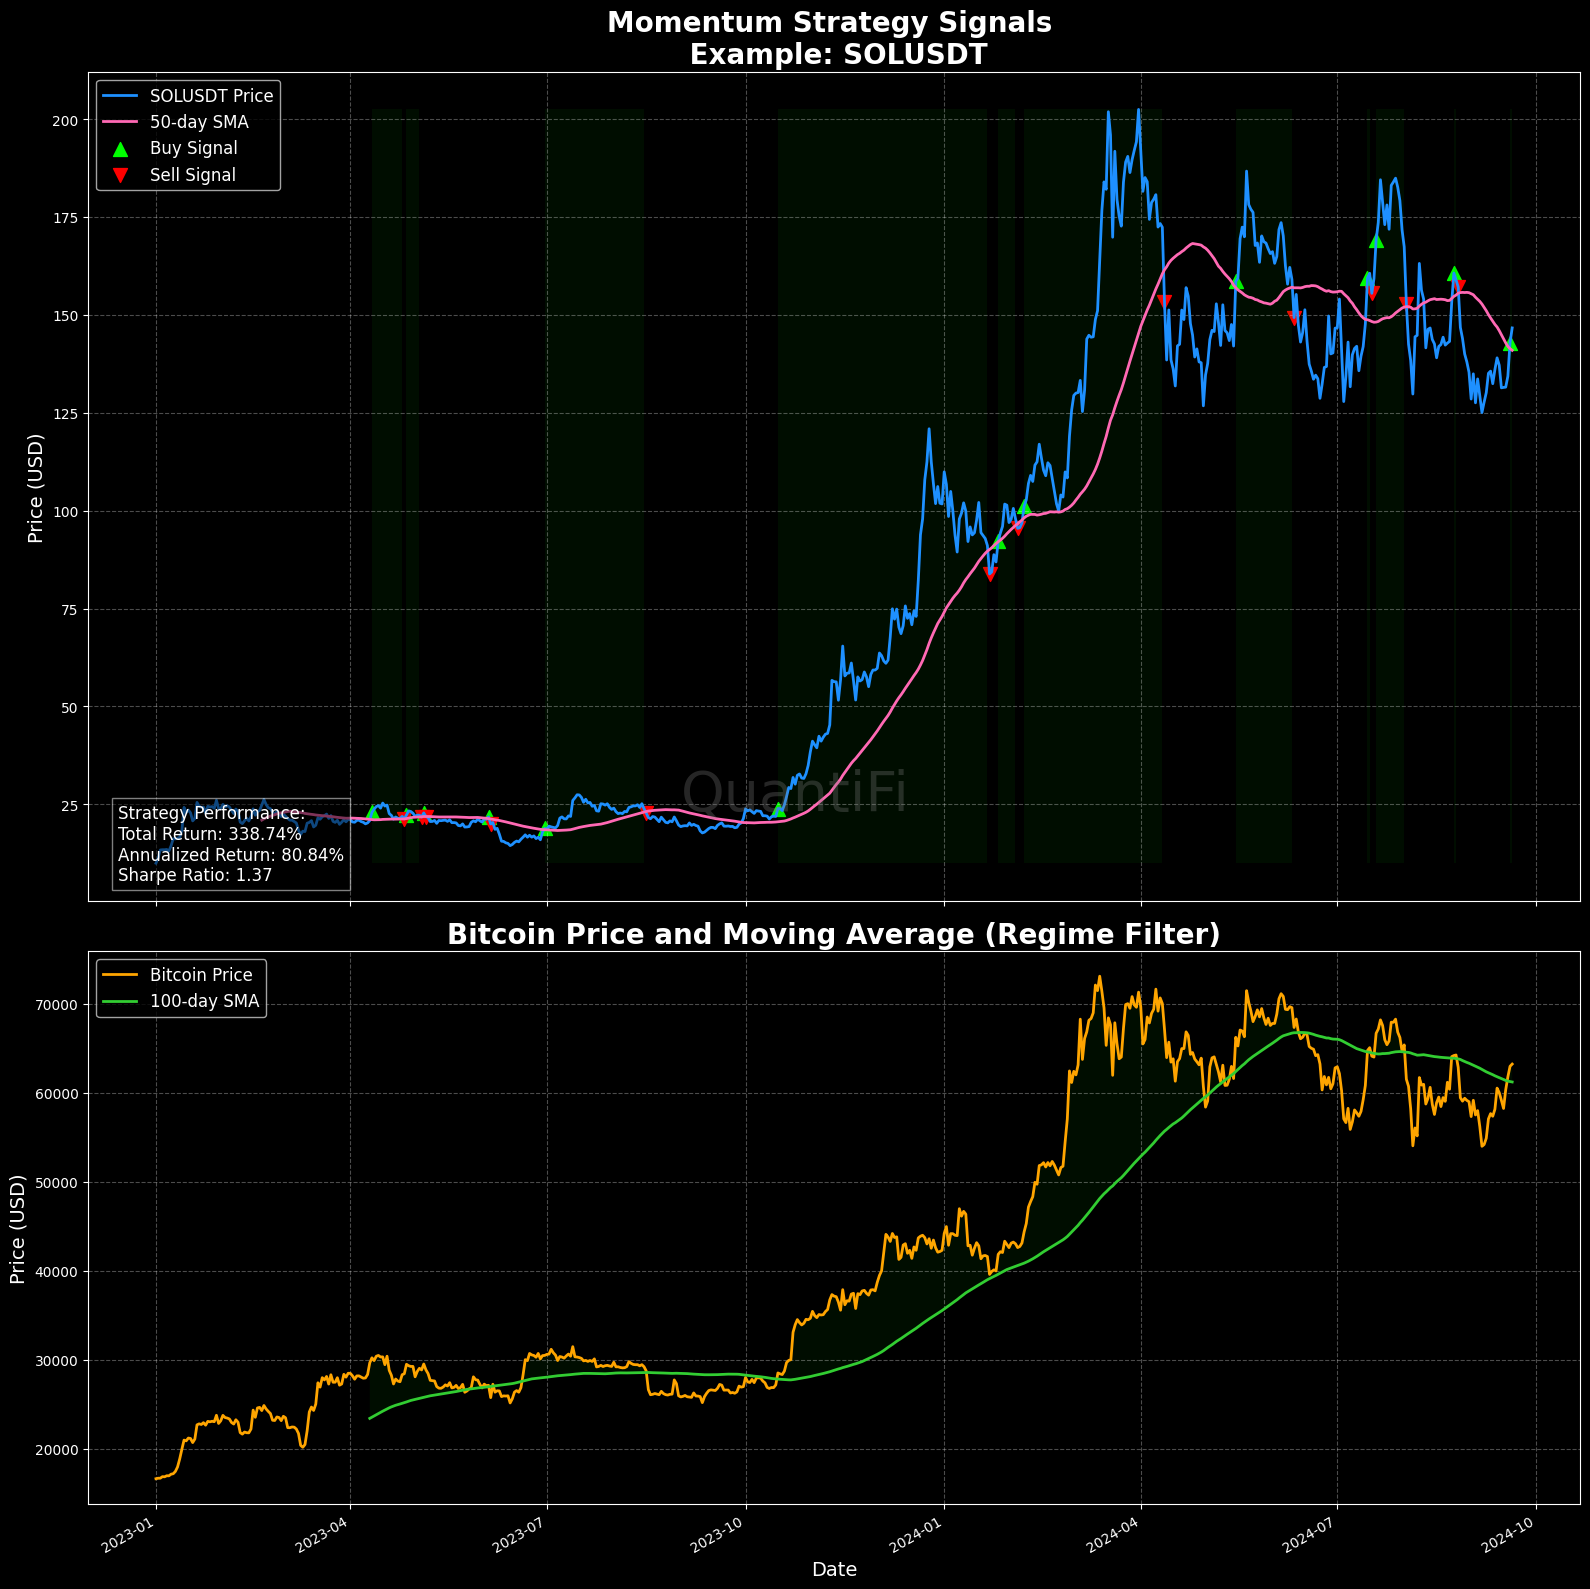

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style

style.use('dark_background')

def backtest(df, coin, btc_window, coin_window):
    df['BTC-SMA'] = df['BTCUSDT'].rolling(btc_window).mean()
    df[f'{coin}-SMA'] = df[coin].rolling(coin_window).mean()
    df['signal'] = 0
    df.loc[(df['BTCUSDT'] > df['BTC-SMA']) & (df[coin] > df[f'{coin}-SMA']), 'signal'] = 1
    df['position'] = df['signal'].shift(1)
    df['strategy_return'] = df[coin].pct_change() * df['position']
    return df

def visualize_strategy(df, coin='ETHUSDT', coin_window=50, btc_window=100):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
    fig.patch.set_facecolor('#000000')

    # Ethereum chart
    ax1.set_facecolor('#000000')
    ax1.plot(df.index, df[coin], color='#1E90FF', label=f'{coin} Price', linewidth=2)
    ax1.plot(df.index, df[f'{coin}-SMA'], color='#FF69B4', label=f'{coin_window}-day SMA', linewidth=2)

    buy_signals = df[df['signal'].diff() == 1]
    sell_signals = df[df['signal'].diff() == -1]

    ax1.scatter(buy_signals.index, buy_signals[coin], color='lime', s=100, marker='^', label='Buy Signal')
    ax1.scatter(sell_signals.index, sell_signals[coin], color='red', s=100, marker='v', label='Sell Signal')

    ax1.fill_between(df.index, df[coin].min(), df[coin].max(), where=df['signal'] == 1, 
                     facecolor='green', alpha=0.1)

    ax1.set_title(f'Momentum Strategy Signals \n Example: {coin}', fontsize=20, fontweight='bold', color='white')
    ax1.set_ylabel('Price (USD)', fontsize=14, color='white')
    ax1.tick_params(axis='both', colors='white')
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Add strategy performance text to Ethereum chart
    total_return = (1 + df['strategy_return']).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(df)) - 1
    sharpe_ratio = np.sqrt(252) * df['strategy_return'].mean() / df['strategy_return'].std()
    
    performance_text = (
        f"Strategy Performance:\n"
        f"Total Return: {total_return:.2%}\n"
        f"Annualized Return: {annualized_return:.2%}\n"
        f"Sharpe Ratio: {sharpe_ratio:.2f}"
    )
    ax1.text(0.02, 0.02, performance_text, fontsize=12, color='white', 
             transform=ax1.transAxes, va='bottom', 
             bbox=dict(facecolor='black', alpha=0.5, edgecolor='white'))

    # Bitcoin chart
    ax2.set_facecolor('#000000')
    ax2.plot(df.index, df['BTCUSDT'], color='#FFA500', label='Bitcoin Price', linewidth=2)
    ax2.plot(df.index, df['BTC-SMA'], color='#32CD32', label=f'{btc_window}-day SMA', linewidth=2)

    ax2.fill_between(df.index, df['BTCUSDT'], df['BTC-SMA'], 
                     where=df['BTCUSDT'] > df['BTC-SMA'], 
                     facecolor='green', alpha=0.1)

    ax2.set_title('Bitcoin Price and Moving Average (Regime Filter)', fontsize=20, fontweight='bold', color='white')
    ax2.set_xlabel('Date', fontsize=14, color='white')
    ax2.set_ylabel('Price (USD)', fontsize=14, color='white')
    ax2.tick_params(axis='both', colors='white')
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.3)

    # X-axis formatting
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()

    # Add QuantiFi watermark
    fig.text(0.5, 0.5, 'QuantiFi', fontsize=40, color='gray', ha='center', va='center', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage
start_date = '2023-01-01'
end_date = '2024-09-20'
btc_window, eth_window = 100, 50

try:
    df = import_data('SOLUSDT', start_date, end_date)
    df = backtest(df, 'SOLUSDT', btc_window, eth_window)
    visualize_strategy(df, coin='SOLUSDT', coin_window=eth_window, btc_window=btc_window)
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [267]:
import pandas as pd
import numpy as np

def calculate_metrics(returns, risk_free_rate=0):
    """Calculate performance metrics for a series of returns."""
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility != 0 else 0
    
    cumulative_returns = (1 + returns).cumprod()
    drawdowns = 1 - cumulative_returns / cumulative_returns.cummax()
    max_drawdown = drawdowns.max()
    avg_drawdown = drawdowns[drawdowns > 0].mean()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Avg Drawdown': avg_drawdown
    }

def compare_metrics(df):
    """Compare metrics for the strategy and buy-and-hold."""
    strategy_returns = df['strategy'].pct_change().dropna()
    buy_hold_returns = df['buy_and_hold'].pct_change().dropna()
    
    strategy_metrics = calculate_metrics(strategy_returns)
    buy_hold_metrics = calculate_metrics(buy_hold_returns)
    
    metrics_df = pd.DataFrame({
        'Strategy': strategy_metrics,
        'Buy and Hold': buy_hold_metrics
    })
    
    return metrics_df

# Assuming we have already run the backtest and have 'df' with 'strategy' and 'buy_and_hold' columns
metrics_comparison = compare_metrics(df)

# If you want to save this to a CSV file:
# metrics_comparison.to_csv('strategy_metrics_comparison.csv')

In [268]:
metrics_comparison

Strategy  Buy and Hold
Total Return       0.911687      1.608791
Annualized Return  0.114284      0.173542
Volatility         0.454388      0.759927
Sharpe Ratio       0.251512      0.228366
Max Drawdown       0.635615      0.784298
Avg Drawdown       0.291911      0.496717

In [254]:
coin = 'TRXUSDT'

df = import_data(coin, '2020-01-01', '2024-09-20')
df = backtest_shadowed(df, coin, 100, 50)
df = backtest_actual(df, coin)

In [222]:
df['buy_hold'] = (1 + df[coin].pct_change()).cumprod()

<Axes: xlabel='timestamp'>

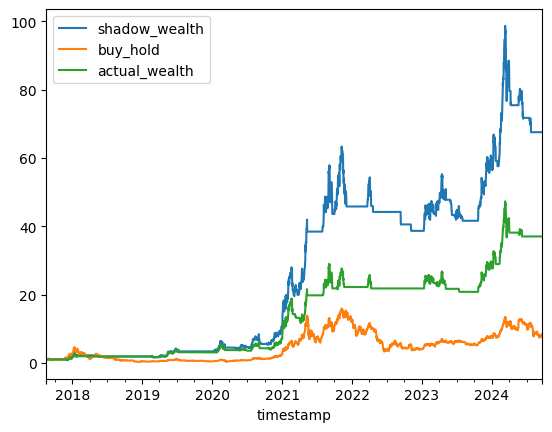

In [223]:
df[['shadow_wealth', 'buy_hold', 'actual_wealth']].plot()

In [195]:
equity_curve = df[['actual_wealth']]
max_dd = max_drawdown(equity_curve)
avg_dd = avg_drawdown(equity_curve)

In [197]:
avg_dd

actual_wealth   -0.233309
dtype: float64

In [136]:
def calculate_drawdowns(equity_curve):
    """Calculate drawdown series from an equity curve."""
    hwm = equity_curve.cummax()
    drawdowns = (equity_curve - hwm) / hwm
    return drawdowns

def max_drawdown(equity_curve):
    """Calculate the maximum drawdown from an equity curve."""
    drawdowns = calculate_drawdowns(equity_curve)
    return drawdowns.min()

def avg_drawdown(equity_curve):
    """Calculate the average drawdown from an equity curve."""
    drawdowns = calculate_drawdowns(equity_curve)
    return drawdowns[drawdowns < 0].mean()

def avg_drawdown_duration(equity_curve):
    """Calculate the average drawdown duration from an equity curve."""
    drawdowns = calculate_drawdowns(equity_curve)
    is_drawdown = drawdowns < 0
    drawdown_groups = (is_drawdown != is_drawdown.shift()).cumsum()[is_drawdown]
    drawdown_lengths = drawdown_groups.groupby(drawdown_groups).size()
    return drawdown_lengths.mean()

In [193]:
df['actual_wealth'].pct_change().mean() * 365 / (df['actual_wealth'].pct_change().std() * np.sqrt(365))

np.float64(1.5307451235119547)

In [113]:
df['shadow_wealth'].pct_change().mean() * 365 / (df['shadow_wealth'].pct_change().std() * np.sqrt(365))

np.float64(2.083818444791877)

<Axes: xlabel='timestamp'>

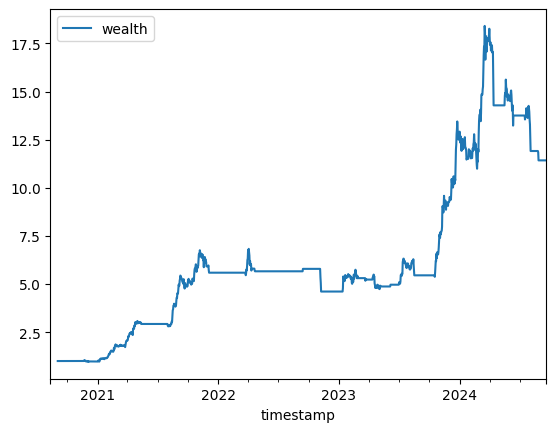

In [121]:
VOL_TARGET = 0.5

coin = 'SOLUSDT'

df = import_data(coin, '2015-01-01', '2024-09-20')
df = get_signals(df, coin, 100, 50)
df['returns'] = df[coin].pct_change()
df['volatility'] = df['returns'].rolling(window=20).std() * np.sqrt(365)
df['position_size'] = np.minimum(1, df['position'] * VOL_TARGET / df['volatility'].shift())
df['strategy_return'] = df['returns'] * df['position_size'].shift()

df['wealth'] = (1 + df['strategy_return']).cumprod()

df[['wealth']].plot()

<Axes: xlabel='timestamp'>

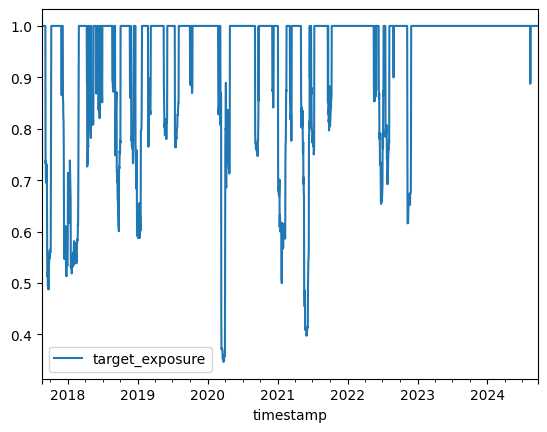

In [85]:
df[['target_exposure']].plot()

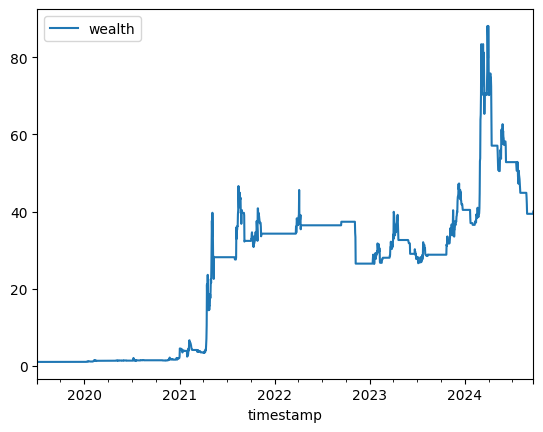

In [72]:
backtest('DOGEUSDT', 100, 20, '2015-01-01', '2024-09-20')

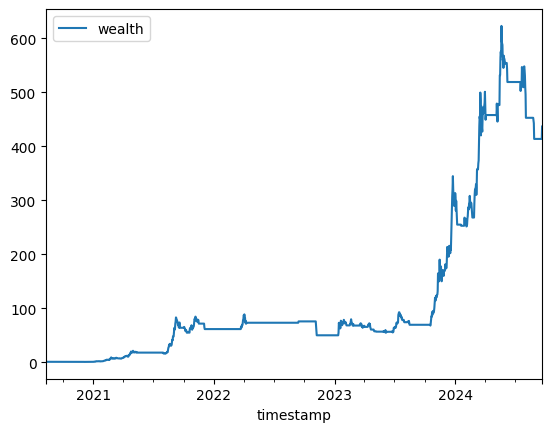

In [71]:
backtest('SOLUSDT', 100, 20, '2015-01-01', '2024-09-20')

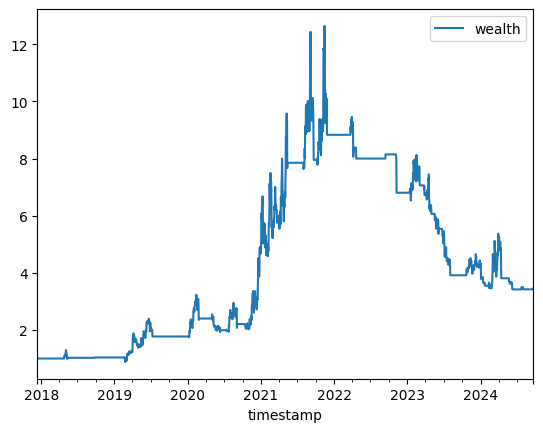

In [70]:
backtest('LTCUSDT', 100, 50, '2015-01-01', '2024-09-20')

In [4]:
def import_binance_data(symbol, start_date='2018-01-01', end_date='2024-09-17', interval='1d', contract='spot'):
    start_str = datetime.strptime(start_date, '%Y-%m-%d')
    start_str = start_str.strftime('%b %-d, %Y')
    end_str = datetime.strptime(end_date, '%Y-%m-%d')
    end_str = end_str.strftime('%b %-d, %Y')
    api_key     = BINANCE_API_KEY
    api_secret  = BINANCE_PRIVATE_KEY
    client = Client(api_key, api_secret)
    if contract == 'futures':
        df = client.futures_historical_klines(symbol, interval=interval, start_str=start_str, end_str=end_str)
    else:
        df = client.get_historical_klines(symbol, interval=interval, start_str=start_str, end_str=end_str)
    df = pd.DataFrame(df)
    df = df.iloc[:, :6]
    df.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.timestamp = pd.to_datetime(df.timestamp, unit='ms')
    df.set_index('timestamp', inplace=True)
    for col in df.columns:
        df[col] = df[col].astype('float')
    
    return df

In [7]:
import_binance_data('SOLUSDT')

Open      High       Low     Close      Volume
timestamp                                                     
2020-09-14    3.2002    4.9100    3.2002    3.2661   4788171.0
2020-09-15    3.2629    3.3258    2.9001    2.9332   4318305.0
2020-09-16    2.9299    2.9299    2.4316    2.5395   5698128.0
2020-09-17    2.5400    2.9360    2.3569    2.8855   6499338.0
2020-09-18    2.8821    3.1500    2.7240    3.1080   6310796.0
...              ...       ...       ...       ...         ...
2024-09-13  135.9970  139.8280  131.6050  138.9160  14962558.0
2024-09-14  138.9160  139.7470  135.4000  137.0680   7913634.0
2024-09-15  137.0620  137.8730  130.3220  131.3190  10475376.0
2024-09-16  131.3200  132.3450  128.8400  131.4120  13155012.0
2024-09-17  131.4110  135.5000  129.8400  131.4670  14957622.0

[1465 rows x 5 columns]

In [32]:
import requests
import pandas as pd
from datetime import datetime

def get_coin_data_messari(asset_key, start_date, end_date):
    url = f"https://data.messari.io/api/v1/assets/{asset_key}/metrics/price/time-series"
    params = {
        "start": start_date,
        "end": end_date,
        "interval": "1d"
    }
    response = requests.get(url, params=params)
    data = response.json()['data']
    
    df = pd.DataFrame(data['values'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop('timestamp', axis=1)
    return df

# Example usage
start_date = "2019-01-01"
end_date = "2024-09-20"
bitcoin_data = get_coin_data_messari('btc', start_date, end_date)
print(bitcoin_data.head())

KeyError: 'data'

In [31]:
ethereum_data

open          high           low         close        volume  \
0    16531.186373  16620.478911  16497.058581  16613.271012  4.211388e+09   
1    16613.771299  16761.289848  16547.702908  16677.047214  5.850932e+09   
2    16669.837754  16766.405265  16607.085737  16671.792216  7.097082e+09   
3    16670.519308  16977.026220  16646.597354  16848.785195  9.213530e+09   
4    16848.658096  16872.415110  16767.440966  16831.161573  6.266151e+09   
..            ...           ...           ...           ...           ...   
624  59140.849903  59208.368996  57520.760112  58206.701027  2.015994e+10   
625  58218.049112  61335.206342  57631.077682  60316.282079  2.462020e+10   
626  60322.745152  61772.663875  59201.585439  61772.663875  2.656954e+10   
627  61803.908334  63870.173663  61611.479228  62959.553593  2.764424e+10   
628  62965.811873  64086.720284  62641.866098  63426.604092  8.974329e+09   

          date  
0   2023-01-01  
1   2023-01-02  
2   2023-01-03  
3   2023-01-04  
4   2023-01-05  
..         ...  
624 2024-09-16  
625 2024-09-17  
626 2024-09-18  
627 2024-09-19  
628 2024-09-20  

[629 rows x 6 columns]

<Axes: xlabel='timestamp'>

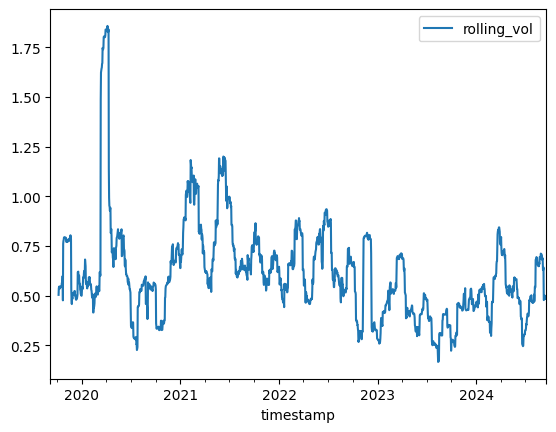

In [39]:
btc['rolling_vol'] = btc['Close'].pct_change().rolling(30).std() * np.sqrt(365)
btc[['rolling_vol']].plot()

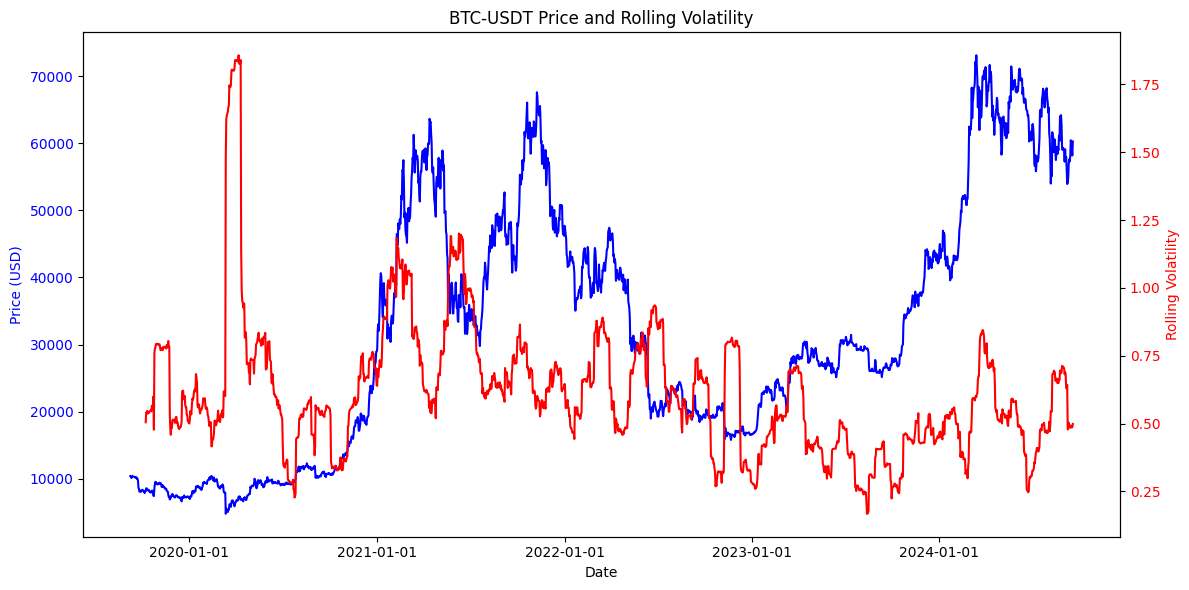

In [40]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

df = btc

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot price on the left y-axis
ax1.plot(df.index, df['Close'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(df.index, df['rolling_vol'], color='red')
ax2.set_ylabel('Rolling Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and format date
plt.title(f'BTC-USDT Price and Rolling Volatility')
ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
import pickle

def load_dataframe_pickle(filename):
    """
    Load a pandas DataFrame using pickle.
    
    :param filename: Name of the file to load from
    :return: pandas DataFrame
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)


In [22]:
assets = load_dataframe_pickle('/Users/Rebecca/Documents/Quantifi/DATA/asset_universe.pkl')

In [23]:
len(assets)

789

In [24]:
assets = [asset.replace('-USD', 'USDT') for asset in assets]

In [25]:
DF = []

no_data_coins = []

for asset in assets:
    try:
        df = import_binance_data(asset)
        DF.append({'symbol': asset, 'data': df})
        print(f'Successfully imported data for {asset}')
    except:
        print(f'Could not import data for {asset}. Skipping.')
        no_data_coins.append(asset)
        continue

Successfully imported data for BTCUSDT
Successfully imported data for XRPUSDT
Successfully imported data for ETHUSDT
Successfully imported data for BCHUSDT
Successfully imported data for EOSUSDT
Successfully imported data for XLMUSDT
Successfully imported data for LTCUSDT
Successfully imported data for BSVUSDT
Successfully imported data for TRXUSDT
Successfully imported data for ADAUSDT
Could not import data for MIOTAUSDT. Skipping.
Successfully imported data for XMRUSDT
Successfully imported data for BNBUSDT
Successfully imported data for DASHUSDT
Successfully imported data for XEMUSDT
Successfully imported data for ETCUSDT
Successfully imported data for NEOUSDT
Successfully imported data for MKRUSDT
Successfully imported data for ZECUSDT
Successfully imported data for WAVESUSDT
Successfully imported data for XTZUSDT
Successfully imported data for DOGEUSDT
Could not import data for BTGUSDT. Skipping.
Successfully imported data for VETUSDT
Successfully imported data for QTUMUSDT
Succes

In [26]:
len(DF)

269

In [42]:
import pandas as pd

# Assuming DF is your list of dictionaries containing 'symbol' and 'data' keys

# Create empty dictionaries for each price type
open_data = {}
high_data = {}
low_data = {}
close_data = {}
volume_data = {}

# Iterate through the DF list
for item in DF:
    symbol = item['symbol']
    df = item['data']
    
    # Populate the dictionaries
    open_data[symbol] = df['Open']
    high_data[symbol] = df['High']
    low_data[symbol] = df['Low']
    close_data[symbol] = df['Close']
    volume_data[symbol] = df['Volume']

# Create DataFrames for each price type
open_df = pd.DataFrame(open_data)
high_df = pd.DataFrame(high_data)
low_df = pd.DataFrame(low_data)
close_df = pd.DataFrame(close_data)
volume_df = pd.DataFrame(volume_data)

# Combine all DataFrames into a multi-level column DataFrame
result_df = pd.concat({
    'Open': open_df,
    'High': high_df,
    'Low': low_df,
    'Close': close_df,
    'Volume': volume_df
}, axis=1)

# Sort the column levels to match yfinance output
result_df = result_df.sort_index(axis=1, level=[1, 0])

# Set the index name to 'Date'
result_df.index.name = 'Date'

# Ensure the index is a DatetimeIndex with UTC timezone
result_df.index = pd.to_datetime(result_df.index, utc=True)

In [48]:
result_df

Close         High          Low         Open  \
                          1000SATSUSDT 1000SATSUSDT 1000SATSUSDT 1000SATSUSDT   
Date                                                                            
2018-01-01 00:00:00+00:00          NaN          NaN          NaN          NaN   
2018-01-02 00:00:00+00:00          NaN          NaN          NaN          NaN   
2018-01-03 00:00:00+00:00          NaN          NaN          NaN          NaN   
2018-01-04 00:00:00+00:00          NaN          NaN          NaN          NaN   
2018-01-05 00:00:00+00:00          NaN          NaN          NaN          NaN   
...                                ...          ...          ...          ...   
2024-09-13 00:00:00+00:00     0.000322     0.000331     0.000309     0.000315   
2024-09-14 00:00:00+00:00     0.000310     0.000330     0.000307     0.000323   
2024-09-15 00:00:00+00:00     0.000287     0.000314     0.000284     0.000310   
2024-09-16 00:00:00+00:00     0.000287     0.000295     0.000281     0.000287   
2024-09-17 00:00:00+00:00     0.000289     0.000302     0.000279     0.000287   

                                 Volume    Close     High      Low     Open  \
                           1000SATSUSDT AAVEUSDT AAVEUSDT AAVEUSDT AAVEUSDT   
Date                                                                          
2018-01-01 00:00:00+00:00           NaN      NaN      NaN      NaN      NaN   
2018-01-02 00:00:00+00:00           NaN      NaN      NaN      NaN      NaN   
2018-01-03 00:00:00+00:00           NaN      NaN      NaN      NaN      NaN   
2018-01-04 00:00:00+00:00           NaN      NaN      NaN      NaN      NaN   
2018-01-05 00:00:00+00:00           NaN      NaN      NaN      NaN      NaN   
...                                 ...      ...      ...      ...      ...   
2024-09-13 00:00:00+00:00  1.864836e+11   144.33   146.45   139.34   145.01   
2024-09-14 00:00:00+00:00  1.399769e+11   140.06   144.35   137.46   144.33   
2024-09-15 00:00:00+00:00  1.850479e+11   143.37   149.96   139.88   140.06   
2024-09-16 00:00:00+00:00  1.742651e+11   140.30   143.80   138.00   143.34   
2024-09-17 00:00:00+00:00  2.372243e+11   140.60   147.50   136.45   140.30   

                               Volume  ...    Close     High      Low  \
                             AAVEUSDT  ...  ZILUSDT  ZILUSDT  ZILUSDT   
Date                                   ...                              
2018-01-01 00:00:00+00:00         NaN  ...      NaN      NaN      NaN   
2018-01-02 00:00:00+00:00         NaN  ...      NaN      NaN      NaN   
2018-01-03 00:00:00+00:00         NaN  ...      NaN      NaN      NaN   
2018-01-04 00:00:00+00:00         NaN  ...      NaN      NaN      NaN   
2018-01-05 00:00:00+00:00         NaN  ...      NaN      NaN      NaN   
...                               ...  ...      ...      ...      ...   
2024-09-13 00:00:00+00:00  331885.751  ...  0.01381  0.01392  0.01347   
2024-09-14 00:00:00+00:00  167604.562  ...  0.01374  0.01401  0.01351   
2024-09-15 00:00:00+00:00  321936.213  ...  0.01328  0.01394  0.01312   
2024-09-16 00:00:00+00:00  265919.992  ...  0.01309  0.01350  0.01286   
2024-09-17 00:00:00+00:00  259492.692  ...  0.01350  0.01362  0.01294   

                              Open       Volume   Close    High     Low  \
                           ZILUSDT      ZILUSDT ZRXUSDT ZRXUSDT ZRXUSDT   
Date                                                                      
2018-01-01 00:00:00+00:00      NaN          NaN     NaN     NaN     NaN   
2018-01-02 00:00:00+00:00      NaN          NaN     NaN     NaN     NaN   
2018-01-03 00:00:00+00:00      NaN          NaN     NaN     NaN     NaN   
2018-01-04 00:00:00+00:00      NaN          NaN     NaN     NaN     NaN   
2018-01-05 00:00:00+00:00      NaN          NaN     NaN     NaN     NaN   
...                            ...          ...     ...     ...     ...   
2024-09-13 00:00:00+00:00  0.01355   88494908.6  0.2987  0.3064  0.2828   
2024-09-14 00:00:0

In [50]:
# Print the column names of the first DataFrame in DF
print(DF[0]['data'].columns)

# Print the first few rows of the first DataFrame
print(DF[0]['data'].head())

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                Open      High       Low     Close        Volume
timestamp                                                       
2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844
2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111
2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639
2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574
2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125


In [27]:
import pandas as pd

# Create empty dictionaries for each price type
close_data = {}
open_data = {}
high_data = {}
low_data = {}
volume_data = {}

# Iterate through the DF list
for item in DF:
    symbol = item['symbol']
    df = item['data']
    
    # Populate the dictionaries
    close_data[symbol] = df[symbol]['Close']
    open_data[symbol] = df[symbol]['Open']
    high_data[symbol] = df[symbol]['High']
    low_data[symbol] = df[symbol]['Low']
    volume_data[symbol] = df[symbol]['Volume']

# Create DataFrames for each price type
close_df = pd.DataFrame(close_data)
open_df = pd.DataFrame(open_data)
high_df = pd.DataFrame(high_data)
low_df = pd.DataFrame(low_data)
volume_df = pd.DataFrame(volume_data)

# Combine all DataFrames into a multi-level column DataFrame
result_df = pd.concat({
    'Close': close_df,
    'Open': open_df,
    'High': high_df,
    'Low': low_df,
    'Volume': volume_df
}, axis=1, names=['Price', 'Ticker'])

# Reorder levels to match the screenshot (Price, Ticker)
result_df = result_df.reorder_levels(['Price', 'Ticker'], axis=1)

# Sort the columns to group by Price type first, then by Ticker
result_df = result_df.sort_index(axis=1)

# Set the index name to 'Date'
result_df.index.name = 'Date'

# Ensure the index is a DatetimeIndex with UTC timezone
result_df.index = pd.to_datetime(result_df.index, utc=True)

# Print the first few rows of the result
print(result_df.head())

KeyError: 'BTCUSDT'

In [28]:
import pandas as pd

# Create empty dictionaries for each price type
close_data = {}
open_data = {}
high_data = {}
low_data = {}
volume_data = {}

# Iterate through the DF list
for item in DF:
    symbol = item['symbol']
    df = item['data']
    
    # Populate the dictionaries
    close_data[symbol] = df['Close']
    open_data[symbol] = df['Open']
    high_data[symbol] = df['High']
    low_data[symbol] = df['Low']
    volume_data[symbol] = df['Volume']

# Create DataFrames for each price type
close_df = pd.DataFrame(close_data)
open_df = pd.DataFrame(open_data)
high_df = pd.DataFrame(high_data)
low_df = pd.DataFrame(low_data)
volume_df = pd.DataFrame(volume_data)

# Combine all DataFrames into a multi-level column DataFrame
result_df = pd.concat({
    'Close': close_df,
    'Open': open_df,
    'High': high_df,
    'Low': low_df,
    'Volume': volume_df
}, axis=1, names=['Price', 'Ticker'])

# Reorder levels to match the screenshot (Price, Ticker)
result_df = result_df.reorder_levels(['Price', 'Ticker'], axis=1)

# Sort the columns to group by Price type first, then by Ticker
result_df = result_df.sort_index(axis=1)

# Set the index name to 'Date'
result_df.index.name = 'Date'

# Ensure the index is a DatetimeIndex with UTC timezone
result_df.index = pd.to_datetime(result_df.index, utc=True)

# Print the first few rows of the result
print(result_df.head())

Price                            Close                                     \
Ticker                    1000SATSUSDT 1INCHUSDT AAVEUSDT ACEUSDT ACHUSDT   
Date                                                                        
2019-09-08 00:00:00+00:00          NaN       NaN      NaN     NaN     NaN   
2019-09-09 00:00:00+00:00          NaN       NaN      NaN     NaN     NaN   
2019-09-10 00:00:00+00:00          NaN       NaN      NaN     NaN     NaN   
2019-09-11 00:00:00+00:00          NaN       NaN      NaN     NaN     NaN   
2019-09-12 00:00:00+00:00          NaN       NaN      NaN     NaN     NaN   

Price                                                                   ...  \
Ticker                    ADAUSDT AERGOUSDT AEVOUSDT AGIXUSDT AKROUSDT  ...   
Date                                                                    ...   
2019-09-08 00:00:00+00:00     NaN       NaN      NaN      NaN      NaN  ...   
2019-09-09 00:00:00+00:00     NaN       NaN      NaN      NaN      

In [29]:
result_df

Price                            Close                                       \
Ticker                    1000SATSUSDT 1INCHUSDT AAVEUSDT ACEUSDT   ACHUSDT   
Date                                                                          
2019-09-08 00:00:00+00:00          NaN       NaN      NaN     NaN       NaN   
2019-09-09 00:00:00+00:00          NaN       NaN      NaN     NaN       NaN   
2019-09-10 00:00:00+00:00          NaN       NaN      NaN     NaN       NaN   
2019-09-11 00:00:00+00:00          NaN       NaN      NaN     NaN       NaN   
2019-09-12 00:00:00+00:00          NaN       NaN      NaN     NaN       NaN   
...                                ...       ...      ...     ...       ...   
2024-09-13 00:00:00+00:00     0.000322    0.2668   144.21  2.2843  0.019242   
2024-09-14 00:00:00+00:00     0.000310    0.2619   139.98  2.2838  0.019390   
2024-09-15 00:00:00+00:00     0.000287    0.2453   143.29  2.1531  0.018393   
2024-09-16 00:00:00+00:00     0.000287    0.2355   140.21  2.0708  0.017918   
2024-09-17 00:00:00+00:00     0.000289    0.2397   140.48  2.2361  0.018188   

Price                                                                   ...  \
Ticker                    ADAUSDT AERGOUSDT AEVOUSDT AGIXUSDT AKROUSDT  ...   
Date                                                                    ...   
2019-09-08 00:00:00+00:00     NaN       NaN      NaN      NaN      NaN  ...   
2019-09-09 00:00:00+00:00     NaN       NaN      NaN      NaN      NaN  ...   
2019-09-10 00:00:00+00:00     NaN       NaN      NaN      NaN      NaN  ...   
2019-09-11 00:00:00+00:00     NaN       NaN      NaN      NaN      NaN  ...   
2019-09-12 00:00:00+00:00     NaN       NaN      NaN      NaN      NaN  ...   
...                           ...       ...      ...      ...      ...  ...   
2024-09-13 00:00:00+00:00  0.3603    0.0965   0.3502   0.7009      NaN  ...   
2024-09-14 00:00:00+00:00  0.3537    0.0940   0.3477   0.7009      NaN  ...   
2024-09-15 00:00:00+00:00  0.3382    0.1002   0.3291   0.7009      NaN  ...   
2024-09-16 00:00:00+00:00  0.3300    0.0938   0.3194   0.7009      NaN  ...   
2024-09-17 00:00:00+00:00  0.3336    0.0981   0.3664   0.7009      NaN  ...   

Price                       Volume                                    \
Ticker                    YFIIUSDT   YFIUSDT     YGGUSDT     ZECUSDT   
Date                                                                   
2019-09-08 00:00:00+00:00      NaN       NaN         NaN         NaN   
2019-09-09 00:00:00+00:00      NaN       NaN         NaN         NaN   
2019-09-10 00:00:00+00:00      NaN       NaN         NaN         NaN   
2019-09-11 00:00:00+00:00      NaN       NaN         NaN         NaN   
2019-09-12 00:00:00+00:00      NaN       NaN         NaN         NaN   
...                            ...       ...         ...         ...   
2024-09-13 00:00:00+00:00      NaN  1275.936  37727858.0  358739.238   
2024-09-14 00:00:00+00:00      NaN  1136.666  41890537.0  208376.947   
2024-09-15 00:00:00+00:00      NaN  1365.479  34369059.0  312563.337   
2024-09-16 00:00:00+00:00      NaN  1133.774  29731911.0  319246.698   
2024-09-17 00:00:00+00:00      NaN   772.523  70238050.0  203982.129   

Price                                                                       \
Ticker                      ZENUSDT     ZETAUSDT      ZILUSDT       ZKUSDT   
Date                                                                         
2019-09-08 00:00:00+00:00       NaN          NaN          NaN          NaN   
2019-09-09 00:00:00+00:00       NaN          NaN          NaN          NaN   
2019-09-10 00:00:00+00:00       NaN          NaN          NaN          NaN   
2019-09-11 00:00:00+00:00       NaN          NaN          NaN          NaN   
2019-09-12 00:00:00+00:00       NaN          NaN          NaN          NaN   
...                             ...          ...          ...          ...   
2024-09-13 00:00:00+00:00  897813.3   31592847.0  335874678.0  225938272.0 

In [34]:
import yfinance as yf

yf.download(tickers=['BTC-USD', 'ETH-USD'])[['Close', 'Open', 'High', 'Low']]

[*********************100%***********************]  2 of 2 completed


Price                             Close                       Open  \
Ticker                          BTC-USD      ETH-USD       BTC-USD   
Date                                                                 
2014-09-17 00:00:00+00:00    457.334015          NaN    465.864014   
2014-09-18 00:00:00+00:00    424.440002          NaN    456.859985   
2014-09-19 00:00:00+00:00    394.795990          NaN    424.102997   
2014-09-20 00:00:00+00:00    408.903992          NaN    394.673004   
2014-09-21 00:00:00+00:00    398.821014          NaN    408.084991   
...                                 ...          ...           ...   
2024-09-14 00:00:00+00:00  60005.121094  2418.595703  60569.117188   
2024-09-15 00:00:00+00:00  59182.835938  2320.897217  60000.726562   
2024-09-16 00:00:00+00:00  58192.507812  2295.283691  59185.226562   
2024-09-17 00:00:00+00:00  60308.539062  2341.707764  58192.507812   
2024-09-18 00:00:00+00:00  59428.585938  2293.374512  60316.382812   

Price                                           High               \
Ticker                         ETH-USD       BTC-USD      ETH-USD   
Date                                                                
2014-09-17 00:00:00+00:00          NaN    468.174011          NaN   
2014-09-18 00:00:00+00:00          NaN    456.859985          NaN   
2014-09-19 00:00:00+00:00          NaN    427.834991          NaN   
2014-09-20 00:00:00+00:00          NaN    423.295990          NaN   
2014-09-21 00:00:00+00:00          NaN    412.425995          NaN   
...                                ...           ...          ...   
2024-09-14 00:00:00+00:00  2441.580811  60656.722656  2442.632080   
2024-09-15 00:00:00+00:00  2418.266113  60381.917969  2430.383301   
2024-09-16 00:00:00+00:00  2320.894531  59205.511719  2334.789795   
2024-09-17 00:00:00+00:00  2295.284424  61316.089844  2392.149170   
2024-09-18 00:00:00+00:00  2341.903320  60716.769531  2341.903320   

Price                               Low               
Ticker                          BTC-USD      ETH-USD  
Date                                                  
2014-09-17 00:00:00+00:00    452.421997          NaN  
2014-09-18 00:00:00+00:00    413.104004          NaN  
2014-09-19 00:00:00+00:00    384.532013          NaN  
2014-09-20 00:00:00+00:00    389.882996          NaN  
2014-09-21 00:00:00+00:00    393.181000          NaN  
...                                 ...          ...  
2024-09-14 00:00:00+00:00  59517.882812  2386.979736  
2024-09-15 00:00:00+00:00  58696.308594  2286.628174  
2024-09-16 00:00:00+00:00  57501.339844  2253.715088  
2024-09-17 00:00:00+00:00  57628.070312  2263.792969  
2024-09-18 00:00:00+00:00  59428.585938  2286.022949  

[3655 rows x 8 columns]

In [ ]:
result

In [31]:
def save_dataframe_pickle(df, filename):
    """
    Save a pandas DataFrame using pickle.
    
    :param df: pandas DataFrame to save
    :param filename: Name of the file to save to
    """
    with open(filename, 'wb') as f:
        pickle.dump(df, f)

save_dataframe_pickle(result_df, '/Users/Rebecca/Documents/Quantifi/DATA/binance_crypto_futures_data_20190908-20240917.pkl')